In [1]:
import os, sys

os.chdir('Petreanu_MEI_generation')
sys.path.append(os.getcwd())

print(os.getcwd())

d:\Python\Anastasia\Petreanu Lab\Petreanu_MEI_generation


In [2]:
import sys
import os
import torch
import numpy as np
import pandas as pd
import mei.legacy
import matplotlib.pyplot as plt
import seaborn as sns
import sensorium
import warnings
from tqdm.auto import tqdm
from nnfabrik.builder import get_data, get_model
from gradient_ascent import gradient_ascent
from sensorium.utility import get_signal_correlations
from sensorium.utility.measure_helpers import get_df_for_scores
from sensorium.utility.training import read_config
from sensorium.models.ensemble import EnsemblePrediction
from neuralpredictors.measures.np_functions import corr
from sensorium.utility.submission import get_data_filetree_loader
from PIL import Image
from scipy import stats

# Set working directory to root of repo
current_path = os.getcwd()
# Identify if path has 'molanalysis' as a folder in it
if 'Petreanu_MEI_generation' in current_path:
    # If so, set the path to the root of the repo
    current_path = current_path.split('Petreanu_MEI_generation')[0] + 'Petreanu_MEI_generation'
else:
    raise FileNotFoundError(
        f'This needs to be run somewhere from within the Petreanu_MEI_generation folder, not {current_path}')
os.chdir(current_path)
sys.path.append(current_path)

print('Working directory:', os.getcwd())

run_config = read_config('run_config.yaml') # Must be set

RUN_NAME = run_config['current_vals']['RUN_NAME'] # MUST be set. Creates a subfolder in the runs folder with this name, containing data, saved models, etc. IMPORTANT: all values in this folder WILL be deleted.
RUN_FOLDER = run_config['current_vals']['RUN_FOLDER']
data_key = f"{run_config['MEIs']['session_id']}-{run_config['MEIs']['session_id']}_{run_config['MEIs']['session_date']}-0"
INPUT_FOLDER = run_config['data']['INPUT_FOLDER']
data_basepath = f'{INPUT_FOLDER}/'
area_of_interest = run_config['current_vals']['data']['area_of_interest']
tier = run_config['MEIs']['tier']
mei_shape = run_config['MEIs']['shape']
num_models = run_config['dev']['num_models']
num_meis = run_config['MEIs']['num_meis']
num_labeled_cells = run_config['MEIs']['num_labeled_cells']
session_id = run_config['MEIs']['session_id']
session_date = run_config['MEIs']['session_date']

print(f'Starting MEI generation for {RUN_NAME}')

# ## Restart Kernel after mei-module installation!

warnings.filterwarnings('ignore')

seed=31415
# data_key_aut = "29027-6-17-1-6-5"
# data_key_wt = "29028-1-17-1-6-5"
# data_key_sens2 = "23964-4-22"
# autistic_mouse_dataPath = "../data/new_data2023/static29027-6-17-1-6-5-GrayImageNetFrame2-7bed7f7379d99271be5d144e5e59a8e7.zip"
# wildtype_mouse_dataPath = "../data/new_data2023/static29028-1-17-1-6-5-GrayImageNetFrame2-7bed7f7379d99271be5d144e5e59a8e7.zip"
# sens2_dataPath = "../data/sensorium_data2022/static23964-4-22-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"

# Loading config only for ensemble 0, because all 5 models have the same config (except
# for the seed and dataloader train/validation split)

# config_file = 'config_m4_ens0.yaml'
config_file = f'{RUN_FOLDER}/config_m4_ens0/config.yaml'
config = read_config(config_file)
config['model_config']['data_path'] = f'{RUN_FOLDER}/data'
print(config)

# Use only one dataloader, since test and final_test are the same for all ensembles
# basepath = "notebooks/data/"
# filenames = [os.path.join(basepath, file) for file in os.listdir(basepath) if ".zip" in file ]
# filenames = [file for file in filenames if 'static26872-17-20' not in file]

basepath = f'{RUN_FOLDER}/data'
# Add Add folders two levels deep from basepath into a list
# First level
folders = [os.path.join(basepath, name) for name in os.listdir(
    basepath) if os.path.isdir(os.path.join(basepath, name)) and not "merged_data" in name]
# Second level
folders = [os.path.join(folder, name) for folder in folders for name in os.listdir(
    folder) if os.path.isdir(os.path.join(folder, name)) and not "merged_data" in name]
folders = [x.replace("\\", "/") for x in folders]
print(folders)

# dataset_fn = 'sensorium.datasets.static_loaders'


dataset_fn = config['dataset_fn']  # 'sensorium.datasets.static_loaders'
dataset_config = {'paths': folders,  # filenames,
                  **config['dataset_config'],
                  }

dataloaders = get_data(dataset_fn, dataset_config)

# Instantiate all five models
model_list = list()

for i in tqdm(range(num_models)):
    # all models have the same parameters
    # e.g. 'sensorium.models.modulated_stacked_core_full_gauss_readout'
    model_fn = config['model_fn']
    model_config = config['model_config']

    model = get_model(model_fn=model_fn,
                      model_config=model_config,
                      dataloaders=dataloaders,
                      seed=config['model_seed'],
                      )

    # Load trained weights from specific ensemble
    # save_file = 'saved_models/config_m4_ens{}/saved_model_v1.pth'.format(i)
    save_file = f'{RUN_FOLDER}/config_m4_ens{i}/saved_model_v1.pth'
    model.load_state_dict(torch.load(save_file))
    model_list.append(model)

ensemble = EnsemblePrediction(model_list, mode='mean')

print("Getting signal correlations")
correlation_to_average = get_signal_correlations(ensemble, dataloaders, tier='test', device='cuda', as_dict=True)

df_cta = get_df_for_scores(session_dict=correlation_to_average, measure_attribute="Correlation to Average")

config_mei = dict(
    initial={"path": "mei.initial.RandomNormal"},
    optimizer={"path": "torch.optim.SGD", "kwargs": {"lr": 1}},
    # transform={"path": "C:\\Users\\asimo\\Documents\\BCCN\\Lab Rotations\\Petreanu Lab\\adrian_sensorium\\notebooks\\submission_m4\\transform.only_keep_1st_dimension"},
    # transform={"path": "transform.only_keep_1st_dimension", "kwargs": {"mei": torch.zeros(1, 4, 64, 64), "i_iteration": 0}},
    # transform={"path": "transform.only_keep_1st_dimension"},#, "kwargs": {"mei": torch.zeros(1, 4, 64, 64), "i_iteration": 0}},
    transform={"path": "transform.OnlyKeep1stDimension"},# "kwargs": {"mei": None, "i_iteration": None}},
    precondition={"path": "mei.legacy.ops.GaussianBlur", "kwargs": {"sigma": 1}},
    postprocessing={"path": "mei.legacy.ops.ChangeNorm", "kwargs": {"norm": 7.5}},
    transparency_weight=0.0,
    stopper={"path": "mei.stoppers.NumIterations", "kwargs": {"num_iterations": 1000}},
    objectives=[
        {"path": "mei.objectives.EvaluationObjective", "kwargs": {"interval": 10}}
    ],
    device="cuda"
)

df_cta = df_cta.loc[df_cta['dataset'] == data_key].reset_index(drop=True)

# top200units = df_cta.sort_values(['Correlation to Average'], ascending=False).reset_index()[:200]['index'].to_list()
# top40units = df_cta.sort_values(['Correlation to Average'], ascending=False).reset_index()[:40]['index'].to_list()

ensemble = ensemble.eval()

pupil_center_config = {"pupil_center": torch.from_numpy(stats.mode([np.mean(np.array(list(dataloaders[i][data_key].dataset._cache['pupil_center'].values())), axis=0) for i in dataloaders]).mode).to(torch.float32).to("cuda:0")}

data_path = os.path.join(data_basepath, data_key.split('-')[1].split('_')[0] + '/' + '_'.join(data_key.split('-')[1].split('_')[1:]))
celldata = pd.read_csv(data_path + '/celldata.csv')
celldata = celldata.loc[celldata['roi_name'] == area_of_interest] if area_of_interest is not None else celldata
assert len(df_cta[df_cta['dataset'] == data_key]) == len(celldata), f"Length of df_cta and celldata not equal, {len(df_cta[df_cta['dataset'] == data_key])} != {len(celldata)} of {data_key}"
df_cta.loc[df_cta['dataset'] == data_key, 'labeled'] = celldata['redcell'].astype(bool).values
df_cta.loc[df_cta['dataset'] == data_key, 'cell_id'] = celldata['cell_id'].values

for loader_key, dataloader in dataloaders[tier].items():
    if loader_key != data_key:
        continue
    trial_indices, image_ids, neuron_ids, responses = get_data_filetree_loader(
        dataloader=dataloader, tier=tier
    )

Working directory: d:\Python\Anastasia\Petreanu Lab\Petreanu_MEI_generation
Starting MEI generation for PM_MEI_in_vivo_validation_with_grid_mean_predictor
{'data_sets': ['all'], 'dataset_fn': 'sensorium.datasets.static_loaders', 'dataset_config': {'normalize': True, 'include_behavior': True, 'include_eye_position': True, 'batch_size': 128, 'scale': 0.25, 'preload_from_merged_data': True, 'include_trial_id': True, 'include_rank_id': True, 'include_history': True, 'include_behav_state': True, 'adjusted_normalization': True, 'use_ensemble_tier': True, 'ensemble_nr': 0}, 'model_fn': 'sensorium.models.modulated_stacked_core_full_gauss_readout', 'model_seed': 100, 'model_config': {'pad_input': False, 'stack': -1, 'layers': 4, 'input_kern': 9, 'gamma_input': 9.8, 'gamma_readout': 0.48, 'hidden_kern': 10, 'hidden_channels': 64, 'depth_separable': True, 'grid_mean_predictor': {'type': 'cortex', 'input_dimensions': 2, 'hidden_layers': 4, 'hidden_features': 20, 'nonlinearity': 'ReLU', 'final_tanh

  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([563])
torch.Size([854])
torch.Size([1157])
torch.Size([1071])
torch.Size([1173])
torch.Size([1735])
torch.Size([903])
torch.Size([1134])
torch.Size([1007])
torch.Size([570])
torch.Size([1214])
torch.Size([150])
torch.Size([737])
torch.Size([563])
torch.Size([854])
torch.Size([1157])
torch.Size([1071])
torch.Size([1173])
torch.Size([1735])
torch.Size([903])
torch.Size([1134])
torch.Size([1007])
torch.Size([570])
torch.Size([1214])
torch.Size([150])
torch.Size([737])
torch.Size([563])
torch.Size([854])
torch.Size([1157])
torch.Size([1071])
torch.Size([1173])
torch.Size([1735])
torch.Size([903])
torch.Size([1134])
torch.Size([1007])
torch.Size([570])
torch.Size([1214])
torch.Size([150])
torch.Size([737])
torch.Size([563])
torch.Size([854])
torch.Size([1157])
torch.Size([1071])
torch.Size([1173])
torch.Size([1735])
torch.Size([903])
torch.Size([1134])
torch.Size([1007])
torch.Size([570])
torch.Size([1214])
torch.Size([150])
torch.Size([737])
torch.Size([563])
torch.Size([854])


In [ ]:
# 2. Exclude neurons within 10um of the scanning fields

# Min and max values of the scanning fields
x_min = 0
x_max = 600
y_min = 0
y_max = 600

# Calculate the max values allowed for the neurons
x_min = x_min + 10
x_max = x_max - 10
y_min = y_min + 10
y_max = y_max - 10

selected_neurons = selected_neurons[np.where((celldata['xloc'].values[selected_neurons] > x_min) & (celldata['xloc'].values[selected_neurons] < x_max) & (celldata['yloc'].values[selected_neurons] > y_min) & (celldata['yloc'].values[selected_neurons] < y_max))[0]]

# 3. Select cells within top 30% of oracle scores of previous selection. Is this step necessary?

# selected_neurons = selected_neurons[np.argsort(oracle_scores[selected_neurons])[::-1][:len(selected_neurons)//3]]

# 4. Iterate for neurons in order of decreasing oracle scores, excluding neurons that are within 20um of it

neurons_to_exclude = []
final_neurons = []
for i in selected_neurons:
    if i in neurons_to_exclude:
        continue
    final_neurons.append(i)
    neurons_to_exclude.extend(np.where(np.linalg.norm(celldata[['xloc', 'yloc', 'depth']].values - celldata[['xloc', 'yloc', 'depth']].values[i], axis=1) < 20)[0])

# 5. Select max num_meis best neurons of which at least 10 are labeled
celldata['index_reset'] = np.arange(len(celldata))
final_neurons_labeled = celldata.iloc[final_neurons].loc[(celldata['redcell'] == True)]['index_reset'].values

if len(final_neurons_labeled) < 10:
    print(f'WARNING: Less than 10 labeled neurons available, {len(final_neurons_labeled)} available. Continuing on...')

final_selection = []
labeled_count = 0

for i in final_neurons:
    if len(final_selection) >= num_meis:
        break
    if i in final_neurons_labeled:
        labeled_count += 1
    final_selection.append(i)

if labeled_count < num_labeled_cells:
    additional_needed = num_labeled_cells - labeled_count
    remaining_labeled = [i for i in final_neurons_labeled if i not in final_selection]

    final_selection.extend(remaining_labeled[:additional_needed])

# 6. Assert that at least num_labeled_cells labeled neurons are selected

# assert celldata.loc[final_neurons, 'redcell'].sum() >= 10, f"Less than 10 labeled neurons selected, {celldata.loc[final_neurons, 'redcell'].sum()} selected"
if celldata.iloc[final_selection]['redcell'].sum() < num_labeled_cells:
    print(f"WARNING: Less than {num_labeled_cells} labeled neurons selected, {celldata.iloc[final_neurons]['redcell'].sum()} selected for MEI generation")
else:
    print(f"Selected {celldata.iloc[final_selection]['redcell'].sum()} labeled neurons for MEI generation")

cell_ids = df_cta.iloc[final_selection]['cell_id'].values

# save cell_ids, final_neurons
df_cell_ids = pd.DataFrame({'cell_id': cell_ids, 'neuron_idx': final_selection})
df_cell_ids.to_csv(f'{RUN_FOLDER}/results/cell_ids.csv', index=False)

meis = []

mei_shape_start = (1, 4) # We prepend this because there's 4 input channels: 1 image and 3 behavioral
mei_shape_start = list(mei_shape_start)
mei_generation_shape = mei_shape_start.copy()
mei_generation_shape.extend(list(mei_shape))

print(f'Generating MEIs with the following shape: {mei_generation_shape}')
print(f'Generating {len(final_selection)} best MEIs out of {len(final_neurons)} neurons selected')
for i in tqdm(final_selection):
    mei_out, _, _ = gradient_ascent(ensemble, config_mei, data_key=data_key, unit=i, seed=seed, shape=tuple(mei_generation_shape), model_config=pupil_center_config) # need to pass all dimensions, but all except the first 1 are set to 0 in the transform
    meis.append(mei_out)
# torch.save(meis, "MEIs/meis.pth")
torch.save(meis, f'{RUN_FOLDER}/meis_top{len(final_selection)}_ensemble.pth')

# Save MEIs in Bonsai format
print('Saving MEIs in Bonsai format')
os.makedirs(f'{RUN_FOLDER}/MEI_Bonsai_images', exist_ok=True)

for imei, mei_out in enumerate(meis):
    mei_out = np.array(mei_out[0, 0, ...])
    mei_out = (mei_out + 1) / 2
    mei_out = np.concatenate((np.full(mei_shape, 0.5),mei_out), axis=1) #add left part of the screen
    mei_out = (mei_out * 255).astype(np.uint8)
    # np.save(os.path.join(outdir,'%d.jpg' % imei),mei_out)
    img = Image.fromarray(mei_out)
    img.save(os.path.join(f'{RUN_FOLDER}/MEI_Bonsai_images','%s.jpg' % cell_ids[imei]), format='JPEG')

    if run_config['MEIs']['also_output_to_local']:
        img.save(os.path.join(run_config['MEIs']['local_output_folder'],'%s.jpg' % cell_ids[imei]), format='JPEG')

fig, axes = plt.subplots(8,5, figsize=(20,20), dpi=300)
fig.suptitle("Mouse MEIs", y=0.91, fontsize=50)
for i in tqdm(range(8)):
    for j in range(5):
        index = i * 5 + j
        # axes[i, j].imshow(meis[index].reshape(4, 68, 135).mean(0), cmap="gray")#, vmin=-1, vmax=1)
        axes[i, j].imshow(meis[index][0, 0, ...], cmap="gray")#, vmin=-1, vmax=1)
        axes[i, j].spines['top'].set_color('black')
        axes[i, j].spines['bottom'].set_color('black')
        axes[i, j].spines['left'].set_color('black')
        axes[i, j].spines['right'].set_color('black')
        axes[i, j].spines['top'].set_linewidth(1)
        axes[i, j].spines['bottom'].set_linewidth(1)
        axes[i, j].spines['left'].set_linewidth(1)
        axes[i, j].spines['right'].set_linewidth(1)
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
plt.subplots_adjust(wspace=-0.25, hspace=-0.1)
# os.makedirs("Plots", exist_ok=True)
# plt.savefig("Plots/MouseMEIsTop200.png", dpi=300)
os.makedirs(f'{RUN_FOLDER}/Plots', exist_ok=True)
plt.savefig(f'{RUN_FOLDER}/Plots/MouseMEIsTop40.png', dpi=300)
# plt.show()

for i, model in enumerate(model_list):
    model = model.eval()
    model_list[i] = model

for model_idx, model in enumerate(model_list):
    print(f"Generating MEIs for model {model_idx}")
    meis = []
    for i in tqdm(final_selection):
        mei_out, _, _ = gradient_ascent(model, config_mei, data_key=data_key, unit=i, seed=seed, shape=tuple(mei_generation_shape)) # need to pass all dimensions, but all except the first 1 are set to 0 in the transform
        meis.append(mei_out)
    # torch.save(meis, f"MEIs/meis_model_{model_idx}.pth")
    torch.save(meis, f'{RUN_FOLDER}/meis_model_{model_idx}.pth')

for k in range(num_models):
    # meis = torch.load(f"MEIs/meis_model_{k}.pth")
    meis = torch.load(f'{RUN_FOLDER}/meis_model_{k}.pth')
    fig, axes = plt.subplots(8,5, figsize=(20,20), dpi=300)
    fig.suptitle(f"Mouse MEIs model {k}", y=0.91, fontsize=50)
    for i in tqdm(range(8)):
        for j in range(5):
            index = i * 5 + j
            axes[i, j].imshow(meis[index].reshape(mei_generation_shape[1:])[0, :, :], cmap="gray")#, vmin=-1, vmax=1)
            axes[i, j].spines['top'].set_color('black')
            axes[i, j].spines['bottom'].set_color('black')
            axes[i, j].spines['left'].set_color('black')
            axes[i, j].spines['right'].set_color('black')
            axes[i, j].spines['top'].set_linewidth(1)
            axes[i, j].spines['bottom'].set_linewidth(1)
            axes[i, j].spines['left'].set_linewidth(1)
            axes[i, j].spines['right'].set_linewidth(1)
            axes[i, j].set_xticks([])
            axes[i, j].set_yticks([])
    plt.subplots_adjust(wspace=-0.25, hspace=-0.1)
    # os.makedirs("Plots", exist_ok=True)
    # plt.savefig(f"Plots/MouseMEIsTop200Model{k}.png", dpi=300)
    os.makedirs(f'{RUN_FOLDER}/Plots', exist_ok=True)
    plt.savefig(f'{RUN_FOLDER}/Plots/MouseMEIsTop40Model{k}.png', dpi=300)
    # plt.show()

meis_list = []

for i in range(num_models):
    # meis_list.append(torch.load(f"MEIs/meis_model_{i}.pth"))
    meis_list.append(torch.load(f'{RUN_FOLDER}/meis_model_{i}.pth'))

meis_list = [torch.stack(meis, dim=0) for meis in meis_list]
meis_list = torch.stack(meis_list, dim=0)

avg_meis = meis_list.mean(dim=0)

fig, axes = plt.subplots(8,5, figsize=(20,20), dpi=300)
fig.suptitle("Mouse MEIs Average", y=0.91, fontsize=50)
for i in tqdm(range(8)):
    for j in range(5):
        index = i * 5 + j
        axes[i, j].imshow(avg_meis[index][0, 0, :, :], cmap="gray")#, vmin=-1, vmax=1)
        axes[i, j].spines['top'].set_color('black')
        axes[i, j].spines['bottom'].set_color('black')
        axes[i, j].spines['left'].set_color('black')
        axes[i, j].spines['right'].set_color('black')
        axes[i, j].spines['top'].set_linewidth(1)
        axes[i, j].spines['bottom'].set_linewidth(1)
        axes[i, j].spines['left'].set_linewidth(1)
        axes[i, j].spines['right'].set_linewidth(1)
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
plt.subplots_adjust(wspace=-0.25, hspace=-0.1)
# os.makedirs("Plots", exist_ok=True)
# plt.savefig("Plots/MouseMEIsTop200Average.png", dpi=300)
os.makedirs(f'{RUN_FOLDER}/Plots', exist_ok=True)
plt.savefig(f'{RUN_FOLDER}/Plots/MouseMEIsTop40Average.png', dpi=300)
# plt.show()


In [1]:
import os, sys

os.chdir('Petreanu_MEI_generation')
sys.path.append(os.getcwd())

print(os.getcwd())

d:\Python\Anastasia\Petreanu Lab\Petreanu_MEI_generation


In [2]:
import sys
import os
import torch
import numpy as np
import pandas as pd
import mei.legacy
import matplotlib.pyplot as plt
import seaborn as sns
import sensorium
import warnings
from tqdm.auto import tqdm
from nnfabrik.builder import get_data, get_model
from gradient_ascent import gradient_ascent
from sensorium.utility import get_signal_correlations
from sensorium.utility.measure_helpers import get_df_for_scores
from sensorium.utility.training import read_config
from sensorium.models.ensemble import EnsemblePrediction
from neuralpredictors.measures.np_functions import corr
from sensorium.utility.submission import get_data_filetree_loader
from PIL import Image
from scipy import stats

# Set working directory to root of repo
current_path = os.getcwd()
# Identify if path has 'molanalysis' as a folder in it
if 'Petreanu_MEI_generation' in current_path:
    # If so, set the path to the root of the repo
    current_path = current_path.split('Petreanu_MEI_generation')[0] + 'Petreanu_MEI_generation'
else:
    raise FileNotFoundError(
        f'This needs to be run somewhere from within the Petreanu_MEI_generation folder, not {current_path}')
os.chdir(current_path)
sys.path.append(current_path)

print('Working directory:', os.getcwd())

run_config = read_config('run_config.yaml') # Must be set

RUN_NAME = run_config['current_vals']['RUN_NAME'] # MUST be set. Creates a subfolder in the runs folder with this name, containing data, saved models, etc. IMPORTANT: all values in this folder WILL be deleted.
RUN_FOLDER = run_config['current_vals']['RUN_FOLDER']
data_key = f"{run_config['MEIs']['session_id']}-{run_config['MEIs']['session_id']}_{run_config['MEIs']['session_date']}-0"
INPUT_FOLDER = run_config['data']['INPUT_FOLDER']
data_basepath = f'{INPUT_FOLDER}/'
area_of_interest = run_config['current_vals']['data']['area_of_interest']
tier = run_config['MEIs']['tier']
mei_shape = run_config['MEIs']['shape']
num_models = run_config['dev']['num_models']
num_meis = run_config['MEIs']['num_meis']
num_labeled_cells = run_config['MEIs']['num_labeled_cells']
session_id = run_config['MEIs']['session_id']
session_date = run_config['MEIs']['session_date']

print(f'Starting MEI generation for {RUN_NAME}')

# ## Restart Kernel after mei-module installation!

warnings.filterwarnings('ignore')

seed=31415
# data_key_aut = "29027-6-17-1-6-5"
# data_key_wt = "29028-1-17-1-6-5"
# data_key_sens2 = "23964-4-22"
# autistic_mouse_dataPath = "../data/new_data2023/static29027-6-17-1-6-5-GrayImageNetFrame2-7bed7f7379d99271be5d144e5e59a8e7.zip"
# wildtype_mouse_dataPath = "../data/new_data2023/static29028-1-17-1-6-5-GrayImageNetFrame2-7bed7f7379d99271be5d144e5e59a8e7.zip"
# sens2_dataPath = "../data/sensorium_data2022/static23964-4-22-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"

# Loading config only for ensemble 0, because all 5 models have the same config (except
# for the seed and dataloader train/validation split)

# config_file = 'config_m4_ens0.yaml'
config_file = f'{RUN_FOLDER}/config_m4_ens0/config.yaml'
config = read_config(config_file)
config['model_config']['data_path'] = f'{RUN_FOLDER}/data'
print(config)

# Use only one dataloader, since test and final_test are the same for all ensembles
# basepath = "notebooks/data/"
# filenames = [os.path.join(basepath, file) for file in os.listdir(basepath) if ".zip" in file ]
# filenames = [file for file in filenames if 'static26872-17-20' not in file]

basepath = f'{RUN_FOLDER}/data'
# Add Add folders two levels deep from basepath into a list
# First level
folders = [os.path.join(basepath, name) for name in os.listdir(
    basepath) if os.path.isdir(os.path.join(basepath, name)) and not "merged_data" in name]
# Second level
folders = [os.path.join(folder, name) for folder in folders for name in os.listdir(
    folder) if os.path.isdir(os.path.join(folder, name)) and not "merged_data" in name]
folders = [x.replace("\\", "/") for x in folders]
print(folders)

# dataset_fn = 'sensorium.datasets.static_loaders'


dataset_fn = config['dataset_fn']  # 'sensorium.datasets.static_loaders'
dataset_config = {'paths': folders,  # filenames,
                  **config['dataset_config'],
                  }

dataloaders = get_data(dataset_fn, dataset_config)

# Instantiate all five models
model_list = list()

for i in tqdm(range(num_models)):
    # all models have the same parameters
    # e.g. 'sensorium.models.modulated_stacked_core_full_gauss_readout'
    model_fn = config['model_fn']
    model_config = config['model_config']

    model = get_model(model_fn=model_fn,
                      model_config=model_config,
                      dataloaders=dataloaders,
                      seed=config['model_seed'],
                      )

    # Load trained weights from specific ensemble
    # save_file = 'saved_models/config_m4_ens{}/saved_model_v1.pth'.format(i)
    save_file = f'{RUN_FOLDER}/config_m4_ens{i}/saved_model_v1.pth'
    model.load_state_dict(torch.load(save_file))
    model_list.append(model)

ensemble = EnsemblePrediction(model_list, mode='mean')

print("Getting signal correlations")
correlation_to_average = get_signal_correlations(ensemble, dataloaders, tier='test', device='cuda', as_dict=True)

df_cta = get_df_for_scores(session_dict=correlation_to_average, measure_attribute="Correlation to Average")

config_mei = dict(
    initial={"path": "mei.initial.RandomNormal"},
    optimizer={"path": "torch.optim.SGD", "kwargs": {"lr": 1}},
    # transform={"path": "C:\\Users\\asimo\\Documents\\BCCN\\Lab Rotations\\Petreanu Lab\\adrian_sensorium\\notebooks\\submission_m4\\transform.only_keep_1st_dimension"},
    # transform={"path": "transform.only_keep_1st_dimension", "kwargs": {"mei": torch.zeros(1, 4, 64, 64), "i_iteration": 0}},
    # transform={"path": "transform.only_keep_1st_dimension"},#, "kwargs": {"mei": torch.zeros(1, 4, 64, 64), "i_iteration": 0}},
    transform={"path": "transform.OnlyKeep1stDimension"},# "kwargs": {"mei": None, "i_iteration": None}},
    precondition={"path": "mei.legacy.ops.GaussianBlur", "kwargs": {"sigma": 1}},
    postprocessing={"path": "mei.legacy.ops.ChangeNorm", "kwargs": {"norm": 7.5}},
    transparency_weight=0.0,
    stopper={"path": "mei.stoppers.NumIterations", "kwargs": {"num_iterations": 1000}},
    objectives=[
        {"path": "mei.objectives.EvaluationObjective", "kwargs": {"interval": 10}}
    ],
    device="cuda"
)

df_cta = df_cta.loc[df_cta['dataset'] == data_key].reset_index(drop=True)

top200units = df_cta.sort_values(['Correlation to Average'], ascending=False).reset_index()[:200]['index'].to_list()
top40units = df_cta.sort_values(['Correlation to Average'], ascending=False).reset_index()[:40]['index'].to_list()

ensemble = ensemble.eval()

pupil_center_config = {"pupil_center": torch.from_numpy(stats.mode([np.mean(np.array(list(dataloaders[i][data_key].dataset._cache['pupil_center'].values())), axis=0) for i in dataloaders]).mode).to(torch.float32).to("cuda:0")}

data_path = os.path.join(data_basepath, data_key.split('-')[1].split('_')[0] + '/' + '_'.join(data_key.split('-')[1].split('_')[1:]))
celldata = pd.read_csv(data_path + '/celldata.csv')
celldata = celldata.loc[celldata['roi_name'] == area_of_interest] if area_of_interest is not None else celldata
assert len(df_cta[df_cta['dataset'] == data_key]) == len(celldata), f"Length of df_cta and celldata not equal, {len(df_cta[df_cta['dataset'] == data_key])} != {len(celldata)} of {data_key}"
df_cta.loc[df_cta['dataset'] == data_key, 'labeled'] = celldata['redcell'].astype(bool).values
df_cta.loc[df_cta['dataset'] == data_key, 'cell_id'] = celldata['cell_id'].values

Working directory: d:\Python\Anastasia\Petreanu Lab\Petreanu_MEI_generation
Starting MEI generation for V1_MEI_in_vivo_validation_with_grid_mean_predictor
{'data_sets': ['all'], 'dataset_fn': 'sensorium.datasets.static_loaders', 'dataset_config': {'normalize': True, 'include_behavior': True, 'include_eye_position': True, 'batch_size': 128, 'scale': 0.25, 'preload_from_merged_data': True, 'include_trial_id': True, 'include_rank_id': True, 'include_history': True, 'include_behav_state': True, 'adjusted_normalization': True, 'use_ensemble_tier': True, 'ensemble_nr': 0}, 'model_fn': 'sensorium.models.modulated_stacked_core_full_gauss_readout', 'model_seed': 100, 'model_config': {'pad_input': False, 'stack': -1, 'layers': 4, 'input_kern': 9, 'gamma_input': 9.8, 'gamma_readout': 0.48, 'hidden_kern': 10, 'hidden_channels': 64, 'depth_separable': True, 'grid_mean_predictor': {'type': 'cortex', 'input_dimensions': 2, 'hidden_layers': 4, 'hidden_features': 20, 'nonlinearity': 'ReLU', 'final_tanh

  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([478])
torch.Size([1745])
torch.Size([1313])
torch.Size([2175])
torch.Size([2769])
torch.Size([1538])
torch.Size([1682])
torch.Size([1298])
torch.Size([1967])
torch.Size([1228])
torch.Size([1449])
torch.Size([1592])
torch.Size([2899])
torch.Size([478])
torch.Size([1745])
torch.Size([1313])
torch.Size([2175])
torch.Size([2769])
torch.Size([1538])
torch.Size([1682])
torch.Size([1298])
torch.Size([1967])
torch.Size([1228])
torch.Size([1449])
torch.Size([1592])
torch.Size([2899])
torch.Size([478])
torch.Size([1745])
torch.Size([1313])
torch.Size([2175])
torch.Size([2769])
torch.Size([1538])
torch.Size([1682])
torch.Size([1298])
torch.Size([1967])
torch.Size([1228])
torch.Size([1449])
torch.Size([1592])
torch.Size([2899])
torch.Size([478])
torch.Size([1745])
torch.Size([1313])
torch.Size([2175])
torch.Size([2769])
torch.Size([1538])
torch.Size([1682])
torch.Size([1298])
torch.Size([1967])
torch.Size([1228])
torch.Size([1449])
torch.Size([1592])
torch.Size([2899])
torch.Size([478]

In [3]:
best_model_idx = 4
meis = torch.load(f'{RUN_FOLDER}/meis_model_{best_model_idx}.pth')

df_cell_ids = pd.read_csv(f'{RUN_FOLDER}/results/cell_ids.csv')

cell_ids = df_cell_ids['cell_id']
cell_ids

0     LPE13959_2025_02_24_4_0009
1     LPE13959_2025_02_24_1_0000
2     LPE13959_2025_02_24_3_0003
3     LPE13959_2025_02_24_2_0005
4     LPE13959_2025_02_24_1_0001
                 ...            
70    LPE13959_2025_02_24_2_0492
71    LPE13959_2025_02_24_1_0008
72    LPE13959_2025_02_24_2_0455
73    LPE13959_2025_02_24_0_0126
74    LPE13959_2025_02_24_0_0001
Name: cell_id, Length: 75, dtype: object

In [4]:

# Save MEIs in Bonsai format
print('Saving MEIs in Bonsai format')
os.makedirs(f'{RUN_FOLDER}/MEI_Bonsai_images', exist_ok=True)

for imei, mei_out in enumerate(meis):
    mei_out = np.array(mei_out[0, 0, ...])
    mei_out = (mei_out + 1) / 2
    mei_out = np.concatenate((np.full(mei_shape, 0.5),mei_out), axis=1) #add left part of the screen
    mei_out = (mei_out * 255).astype(np.uint8)
    # np.save(os.path.join(outdir,'%d.jpg' % imei),mei_out)
    img = Image.fromarray(mei_out)
    img.save(os.path.join(f'{RUN_FOLDER}/MEI_Bonsai_images','%s.jpg' % cell_ids[imei]), format='JPEG')

    if run_config['MEIs']['also_output_to_local']:
        img.save(os.path.join(run_config['MEIs']['local_output_folder'],'%s.jpg' % cell_ids[imei]), format='JPEG')

Saving MEIs in Bonsai format


In [26]:

mei_shape_start = (1, 4) # We prepend this because there's 4 input channels: 1 image and 3 behavioral
mei_shape_start = list(mei_shape_start)
mei_generation_shape = mei_shape_start.copy()
mei_generation_shape.extend(list(mei_shape))

In [28]:
meis[0]

tensor([[[[-1.6326e-14,  6.0660e-14,  1.0346e-13,  ...,  5.1287e-14,
           -1.4147e-13,  1.0143e-13],
          [ 1.5556e-13, -7.8486e-16,  2.3507e-13,  ..., -6.0878e-14,
            1.5915e-13,  5.6872e-14],
          [-1.3971e-13, -1.9434e-14, -8.5418e-14,  ..., -6.6909e-14,
            3.2726e-14, -3.7563e-14],
          ...,
          [-1.3308e-13,  1.6373e-13,  1.7565e-13,  ...,  1.6344e-14,
            2.3714e-14,  4.0572e-14],
          [-8.1205e-14, -4.4076e-14, -6.2182e-14,  ...,  2.1559e-13,
            8.3226e-14,  8.0936e-14],
          [-7.2532e-14, -2.4334e-14, -9.0480e-14,  ...,  6.0461e-14,
           -7.6788e-14, -7.0817e-14]],

         [[ 1.7752e-13,  1.5374e-14, -8.6217e-14,  ..., -4.3191e-14,
           -1.8751e-13,  1.1210e-13],
          [-7.6221e-14,  5.2299e-14,  1.4412e-13,  ..., -1.9035e-13,
            6.9645e-14,  4.9901e-14],
          [-3.6451e-14, -4.7887e-15,  6.3445e-14,  ..., -5.1409e-14,
           -1.6669e-13,  3.0984e-13],
          ...,
     

  0%|          | 0/8 [00:00<?, ?it/s]

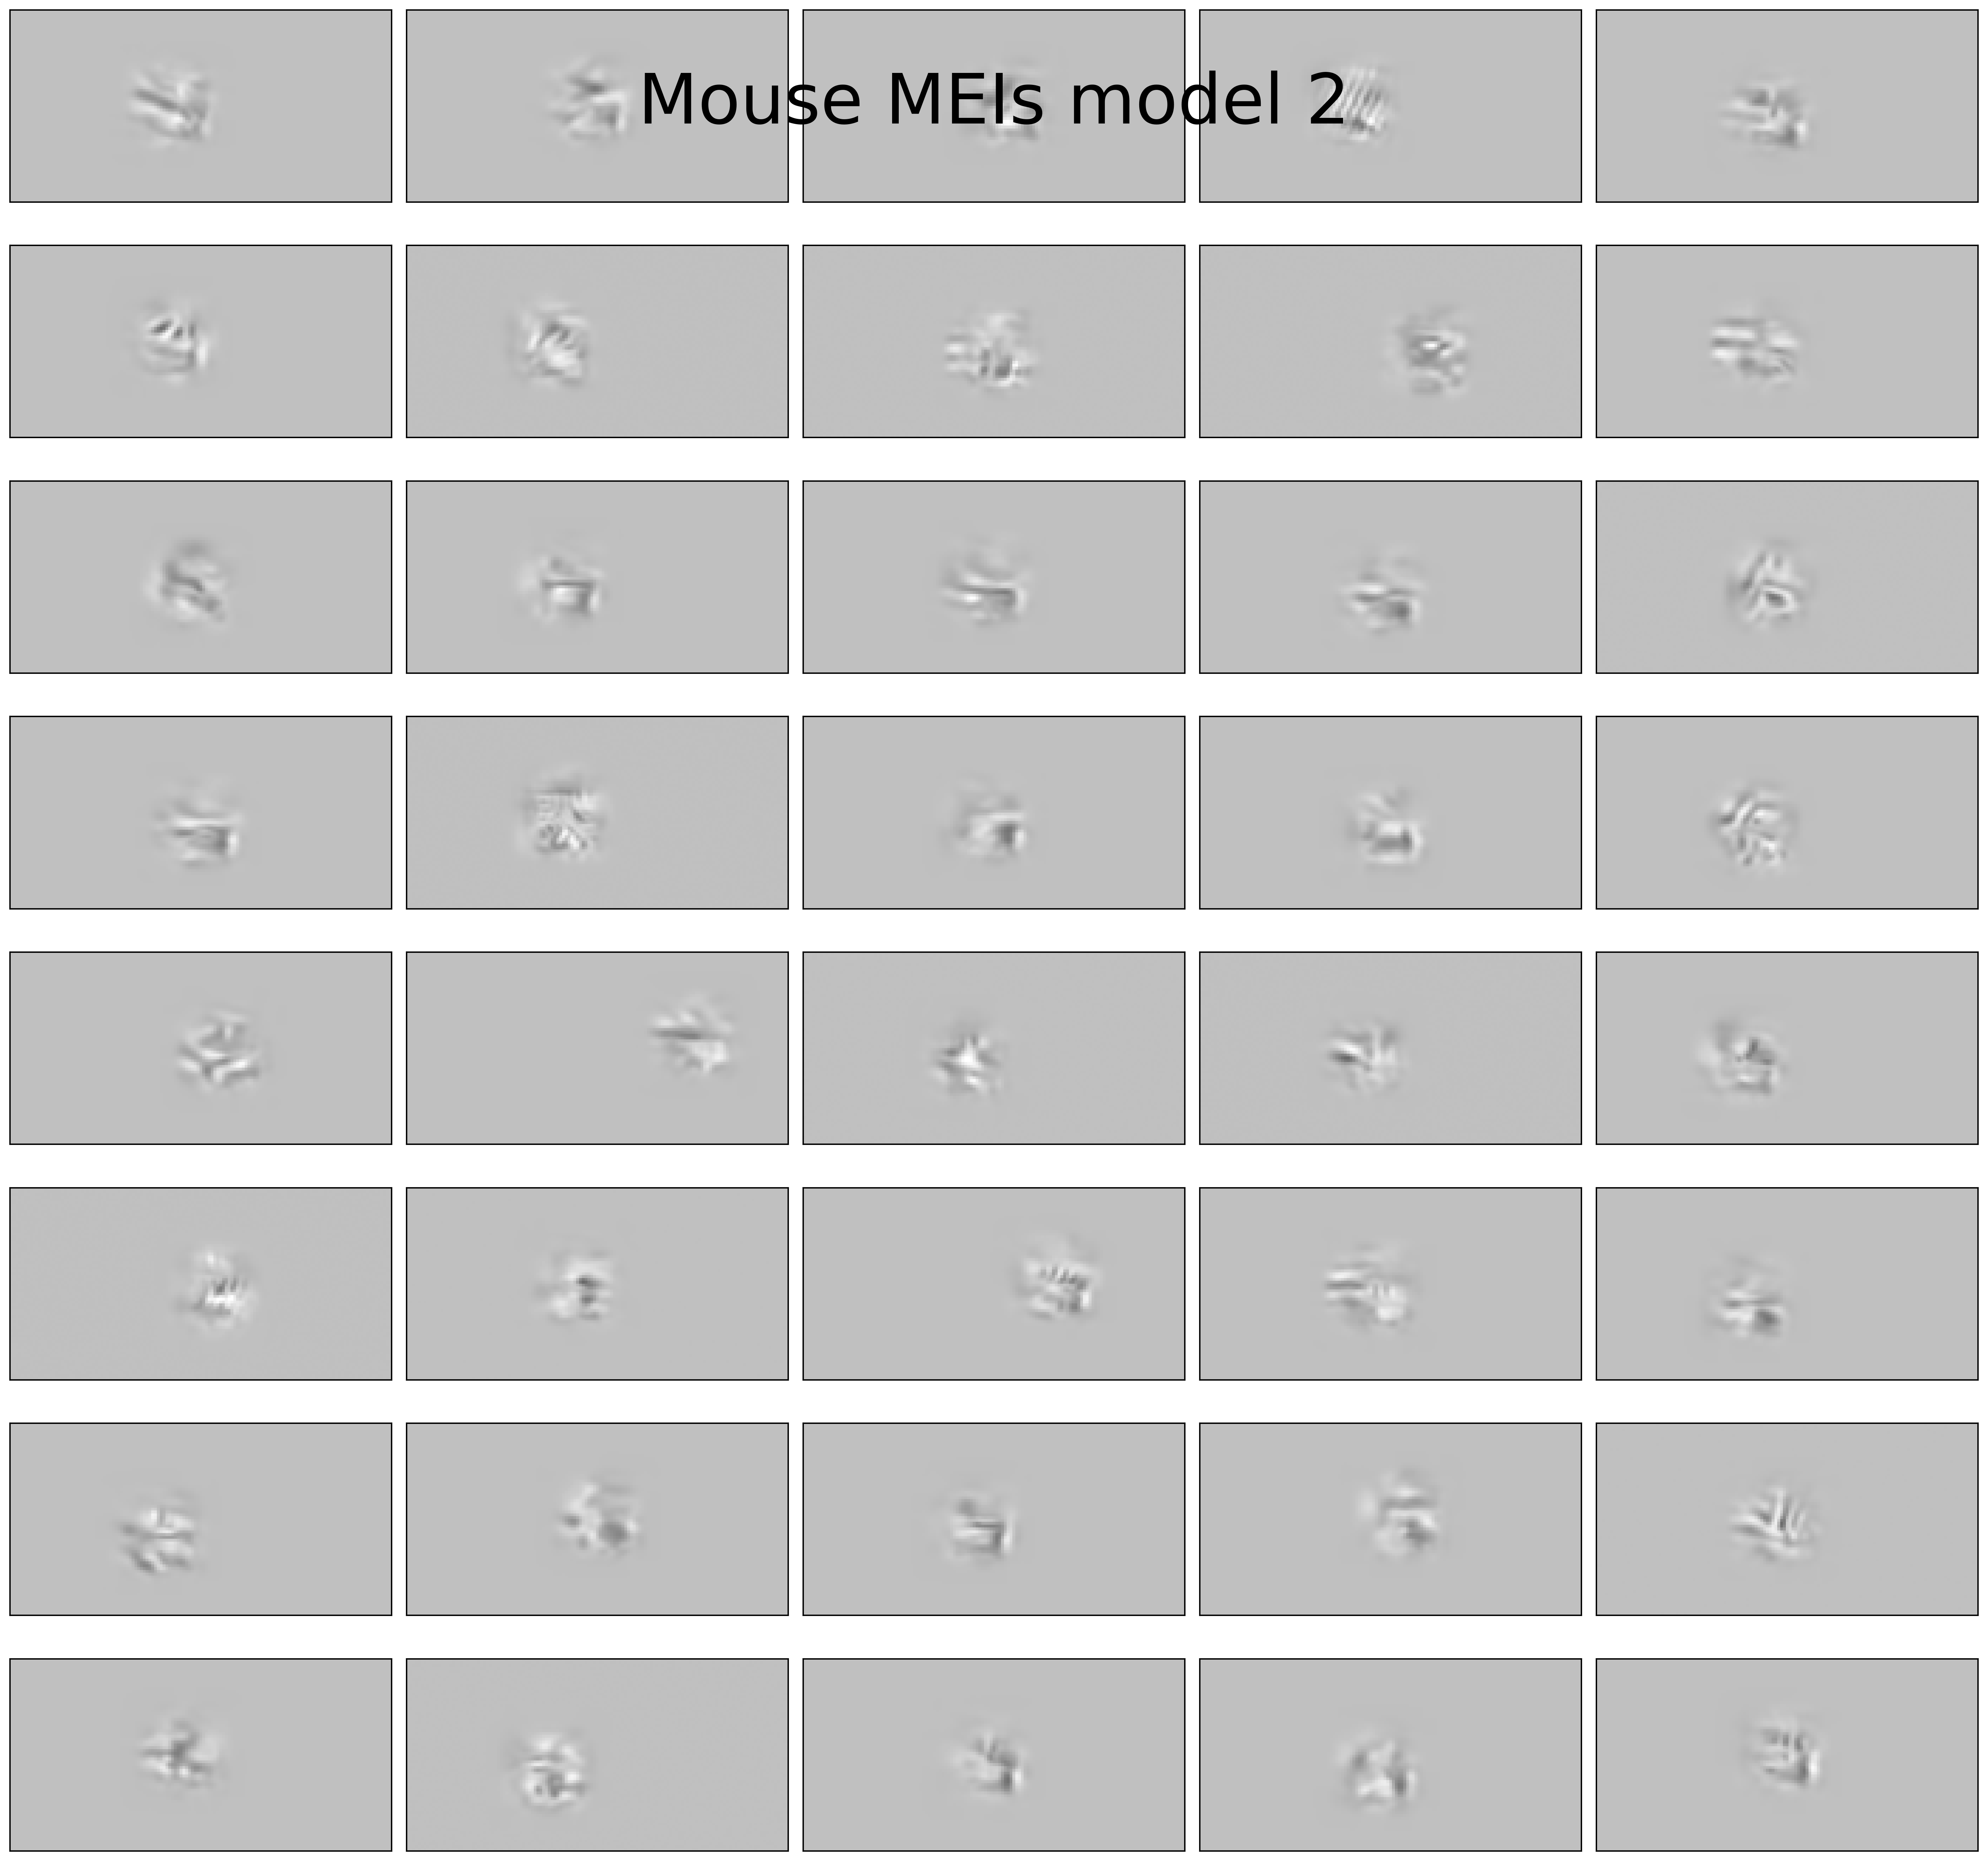

In [32]:
# meis = torch.load(f"MEIs/meis_model_{k}.pth")
fig, axes = plt.subplots(8,5, figsize=(20,20), dpi=300)
fig.suptitle(f"Mouse MEIs model {best_model_idx}", y=0.91, fontsize=50)
for i in tqdm(range(8)):
    for j in range(5):
        index = i * 5 + j
        meis[index] = (meis[index] + 1) / 2
        axes[i, j].imshow(meis[index].reshape(mei_generation_shape[1:])[0, :, :], cmap="gray", vmin=-1, vmax=1)
        axes[i, j].spines['top'].set_color('black')
        axes[i, j].spines['bottom'].set_color('black')
        axes[i, j].spines['left'].set_color('black')
        axes[i, j].spines['right'].set_color('black')
        axes[i, j].spines['top'].set_linewidth(1)
        axes[i, j].spines['bottom'].set_linewidth(1)
        axes[i, j].spines['left'].set_linewidth(1)
        axes[i, j].spines['right'].set_linewidth(1)
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
plt.subplots_adjust(wspace=-0.25, hspace=-0.1)
fig.tight_layout()
# os.makedirs("Plots", exist_ok=True)
# plt.savefig(f"Plots/MouseMEIsTop200Model{k}.png", dpi=300)
os.makedirs(f'{RUN_FOLDER}/Plots', exist_ok=True)
# plt.savefig(f'{RUN_FOLDER}/Plots/MouseMEIsTop40Model{k}.png', dpi=300)
plt.show()


  0%|          | 0/8 [00:00<?, ?it/s]

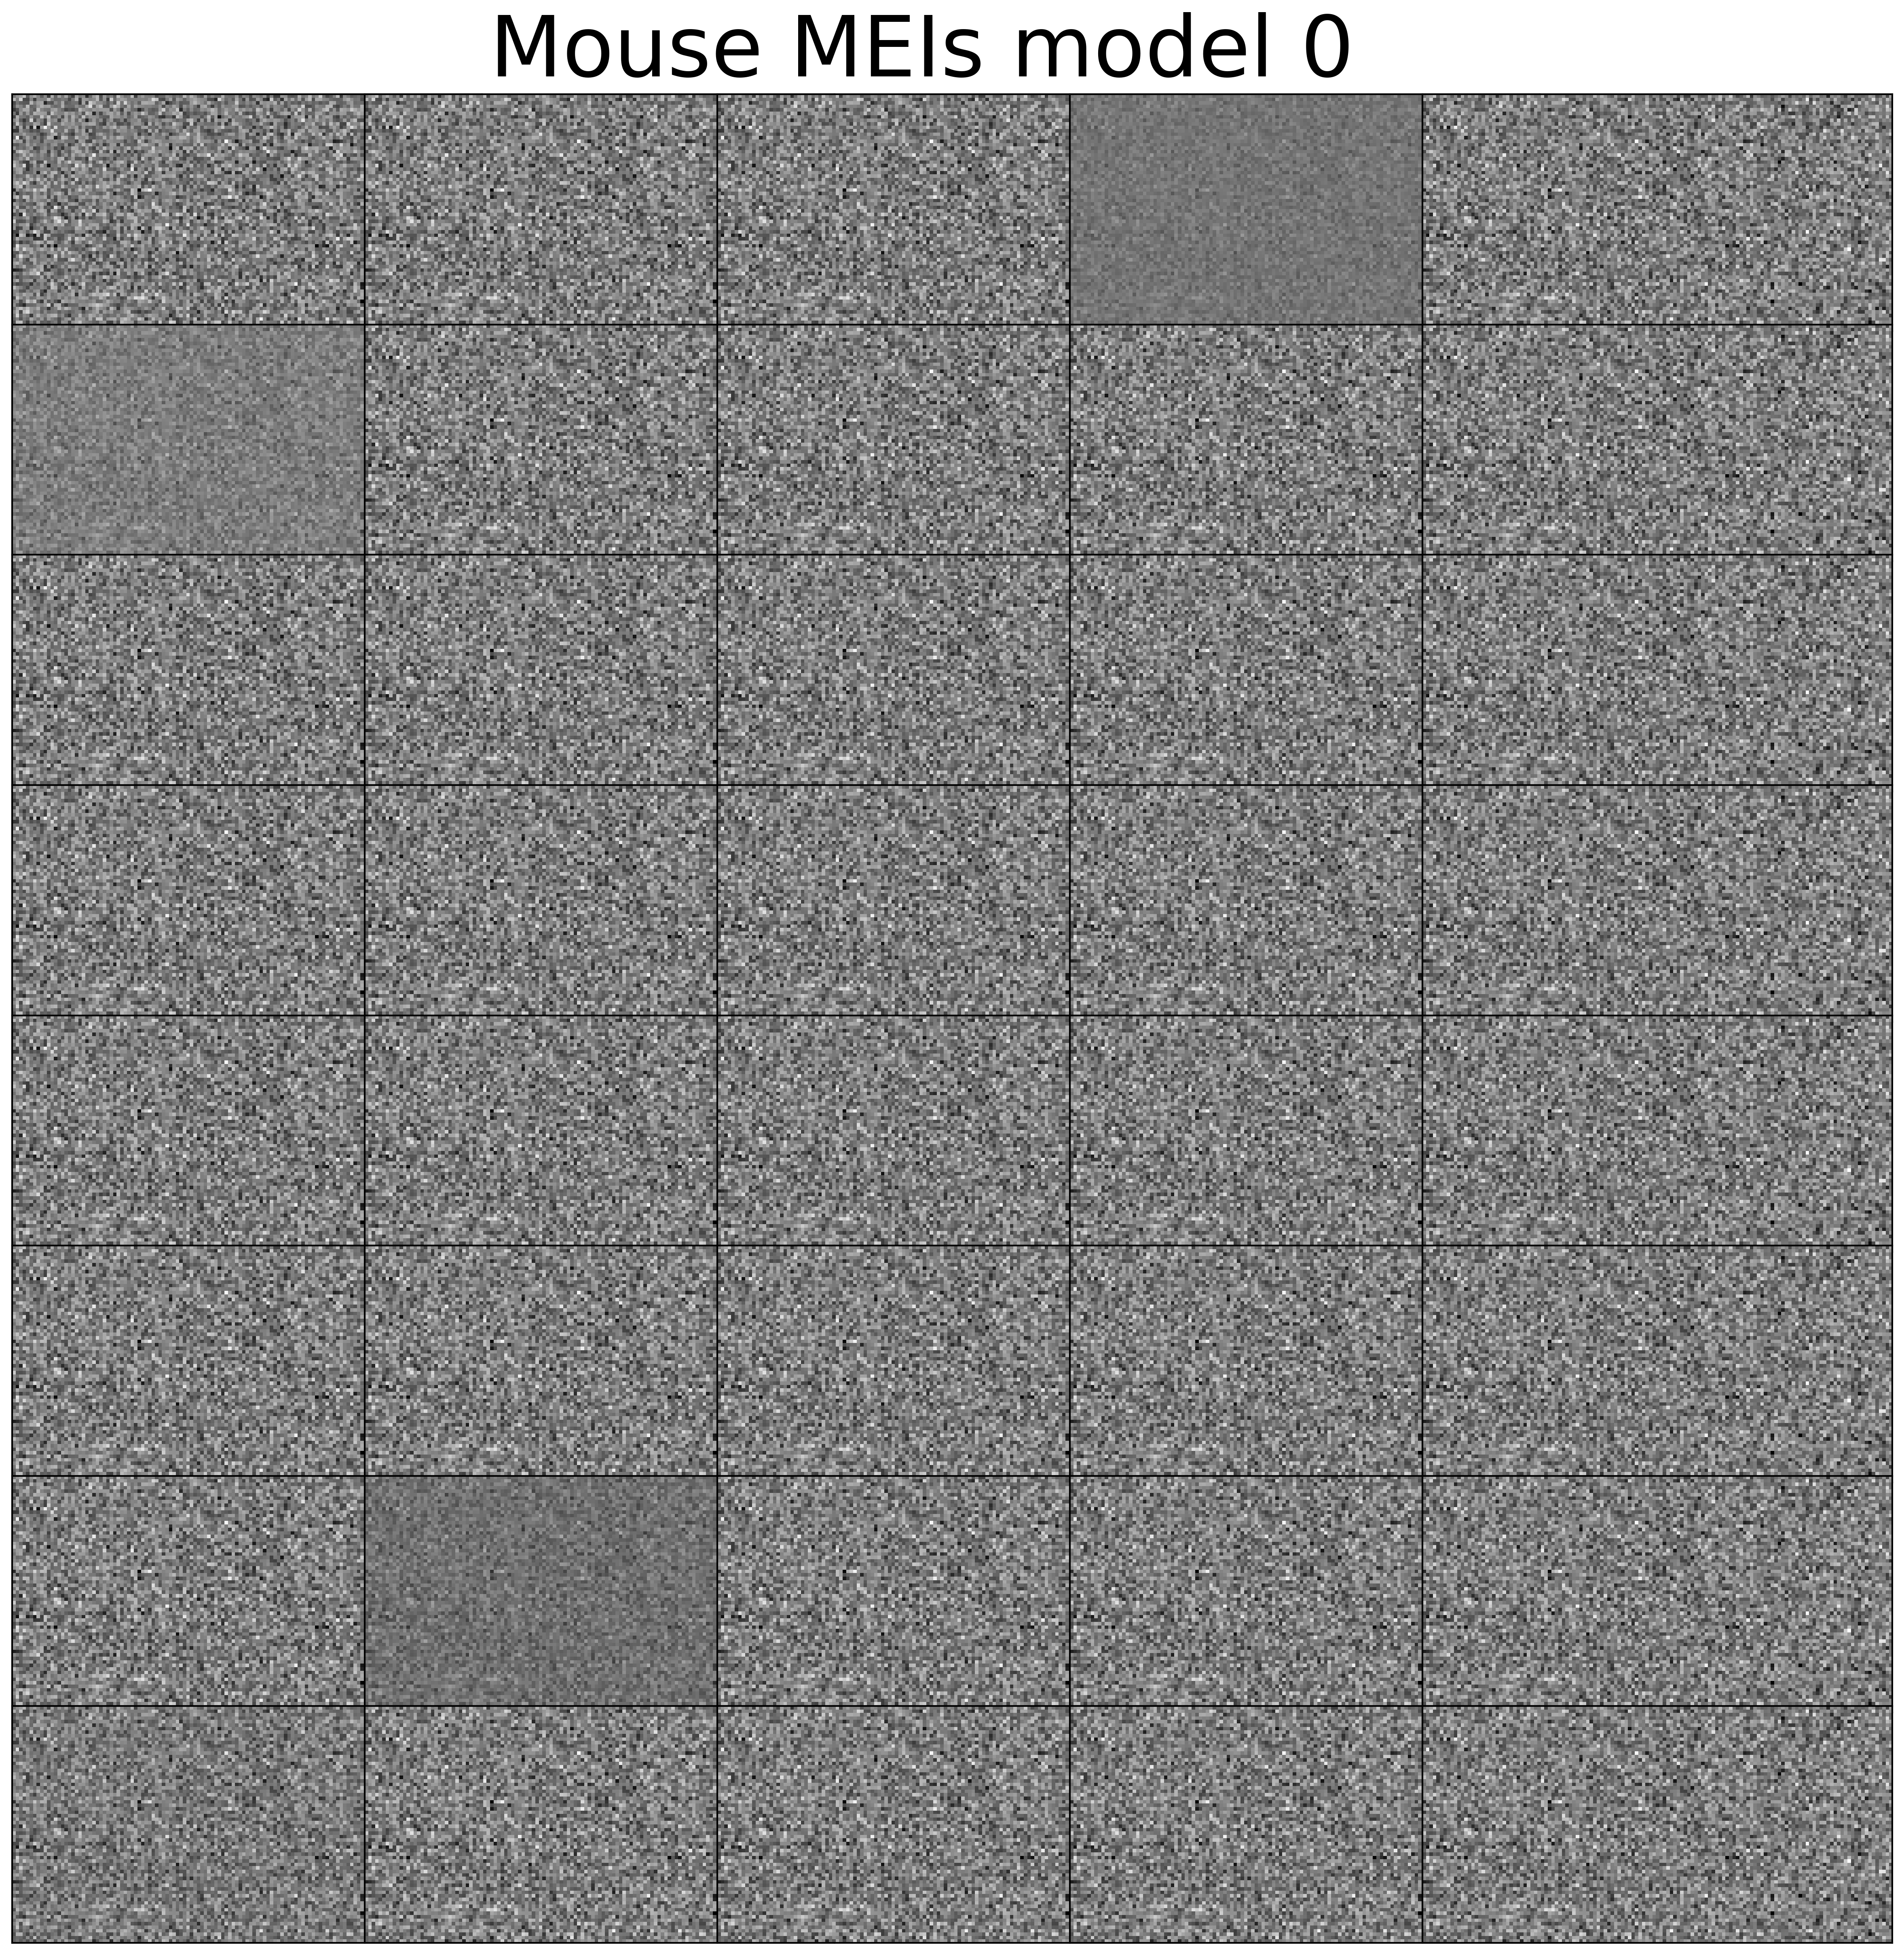

  0%|          | 0/8 [00:00<?, ?it/s]

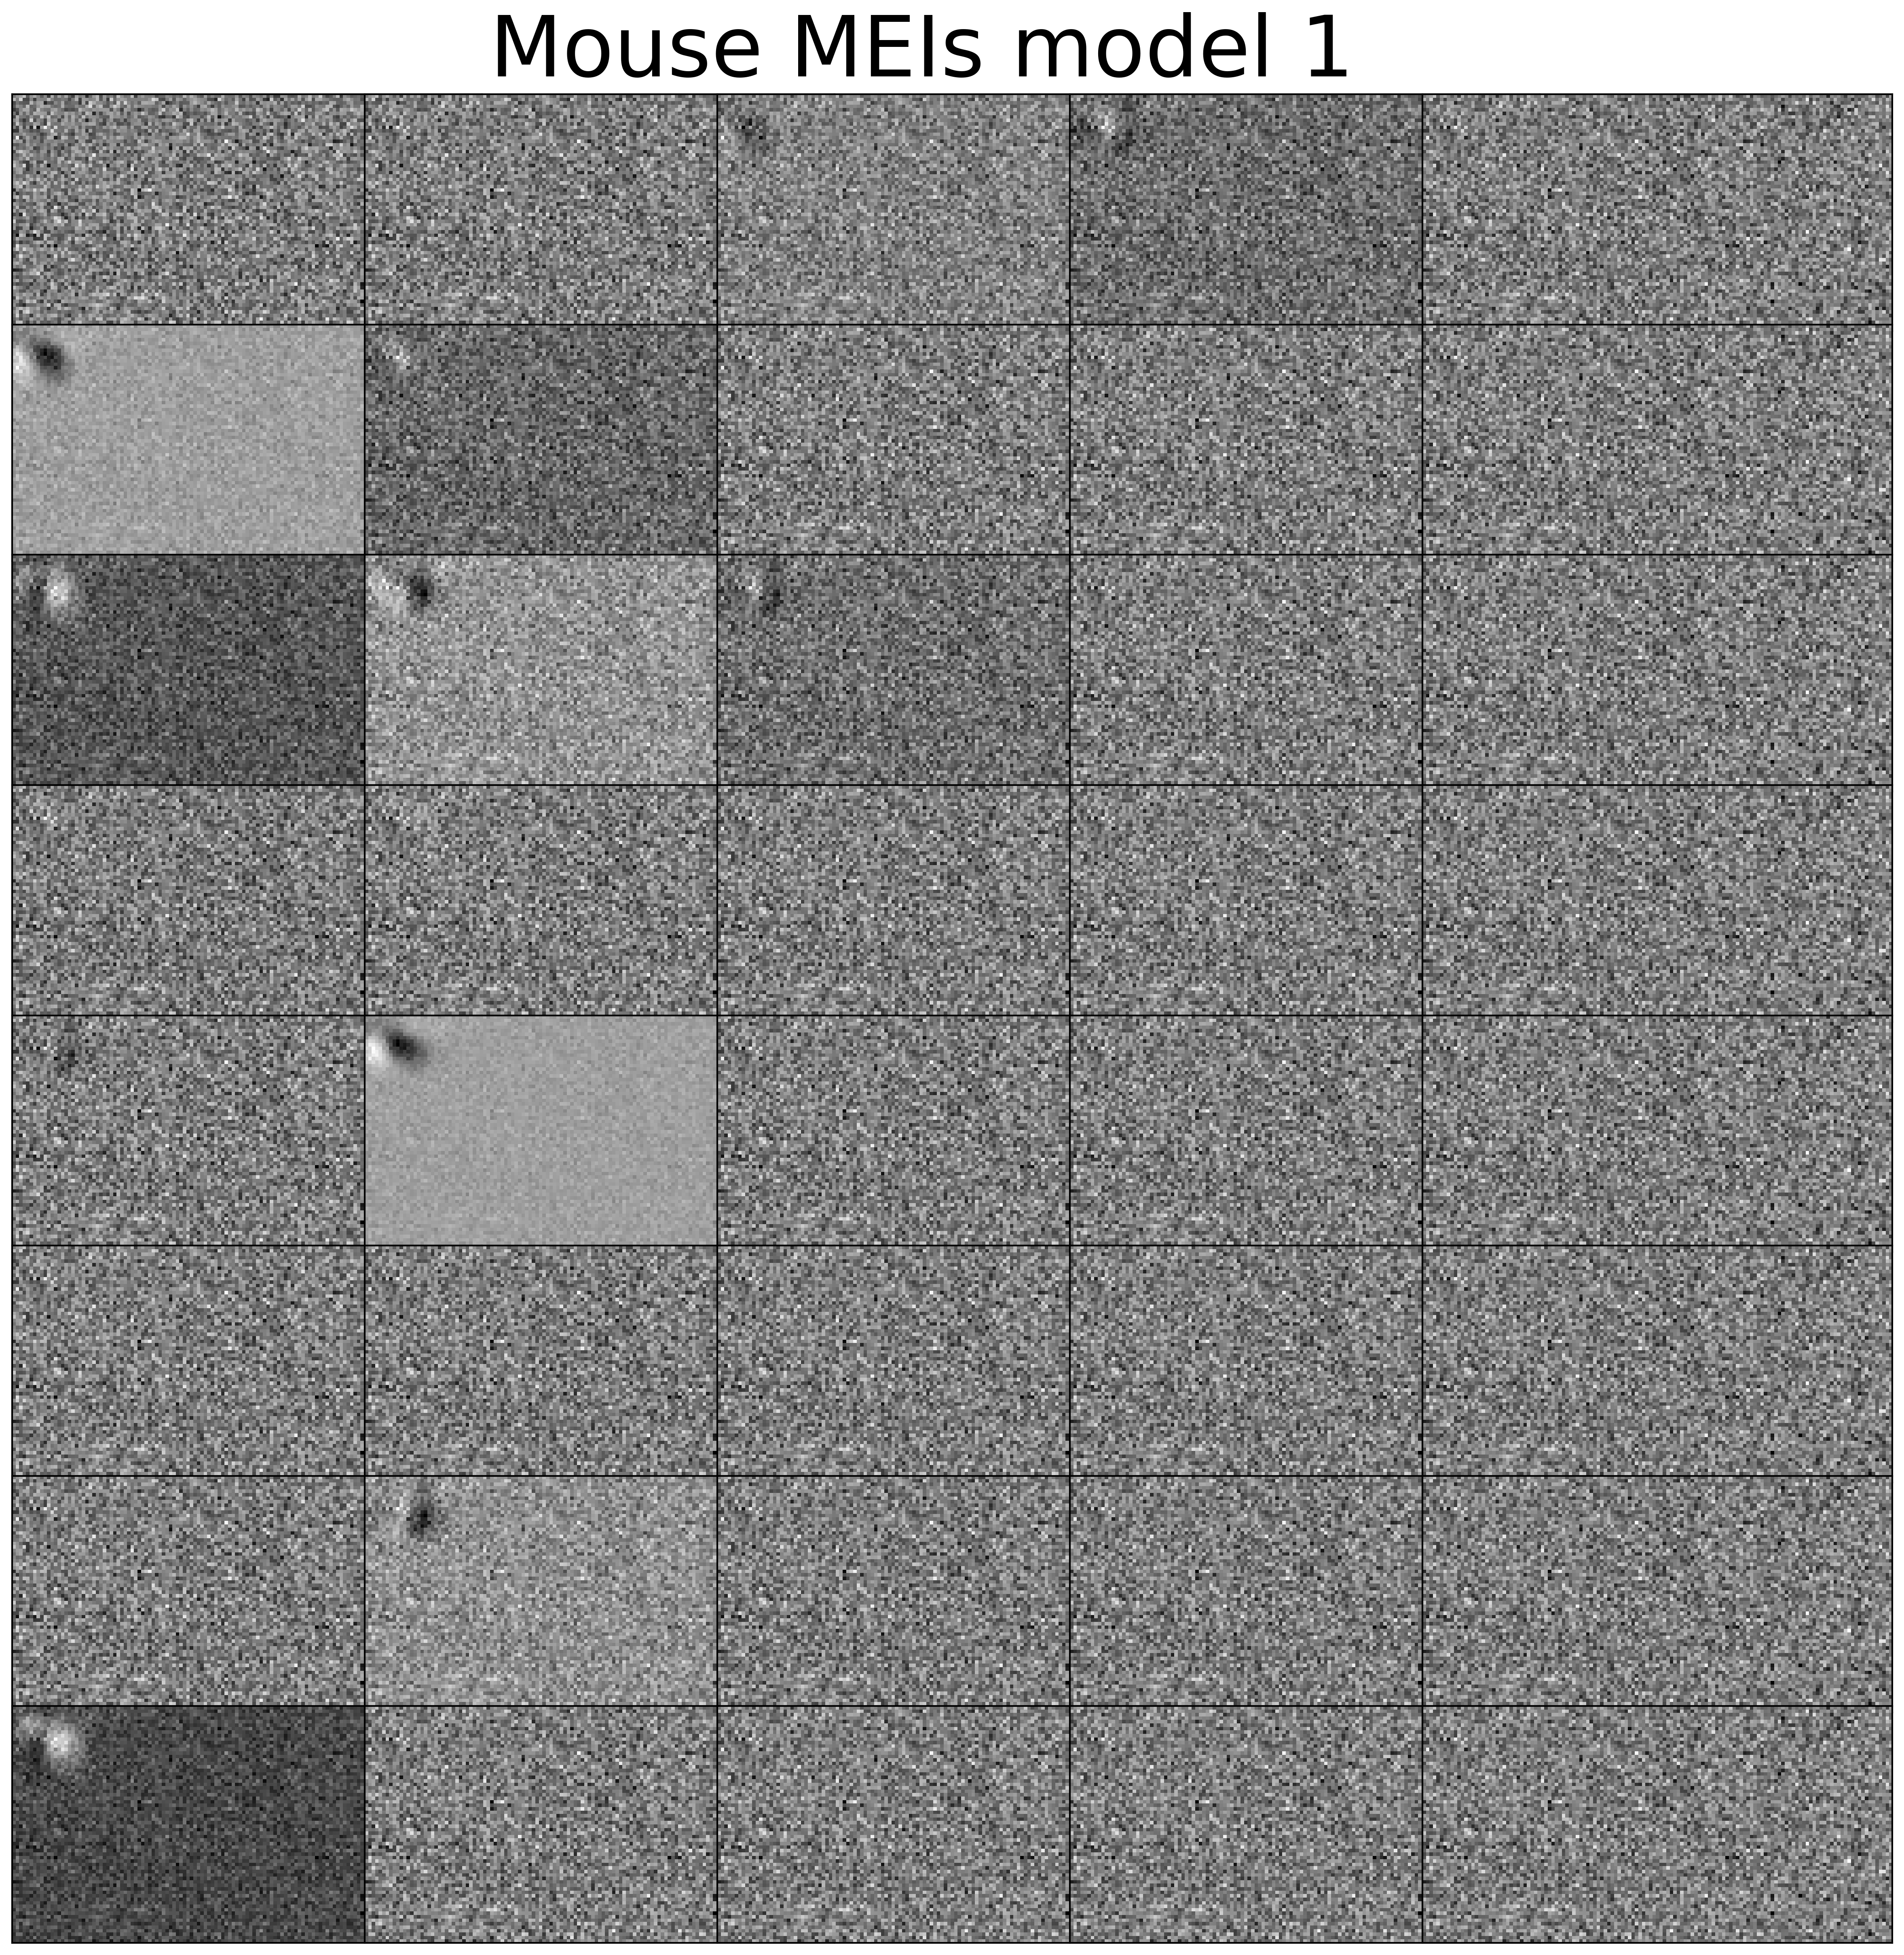

  0%|          | 0/8 [00:00<?, ?it/s]

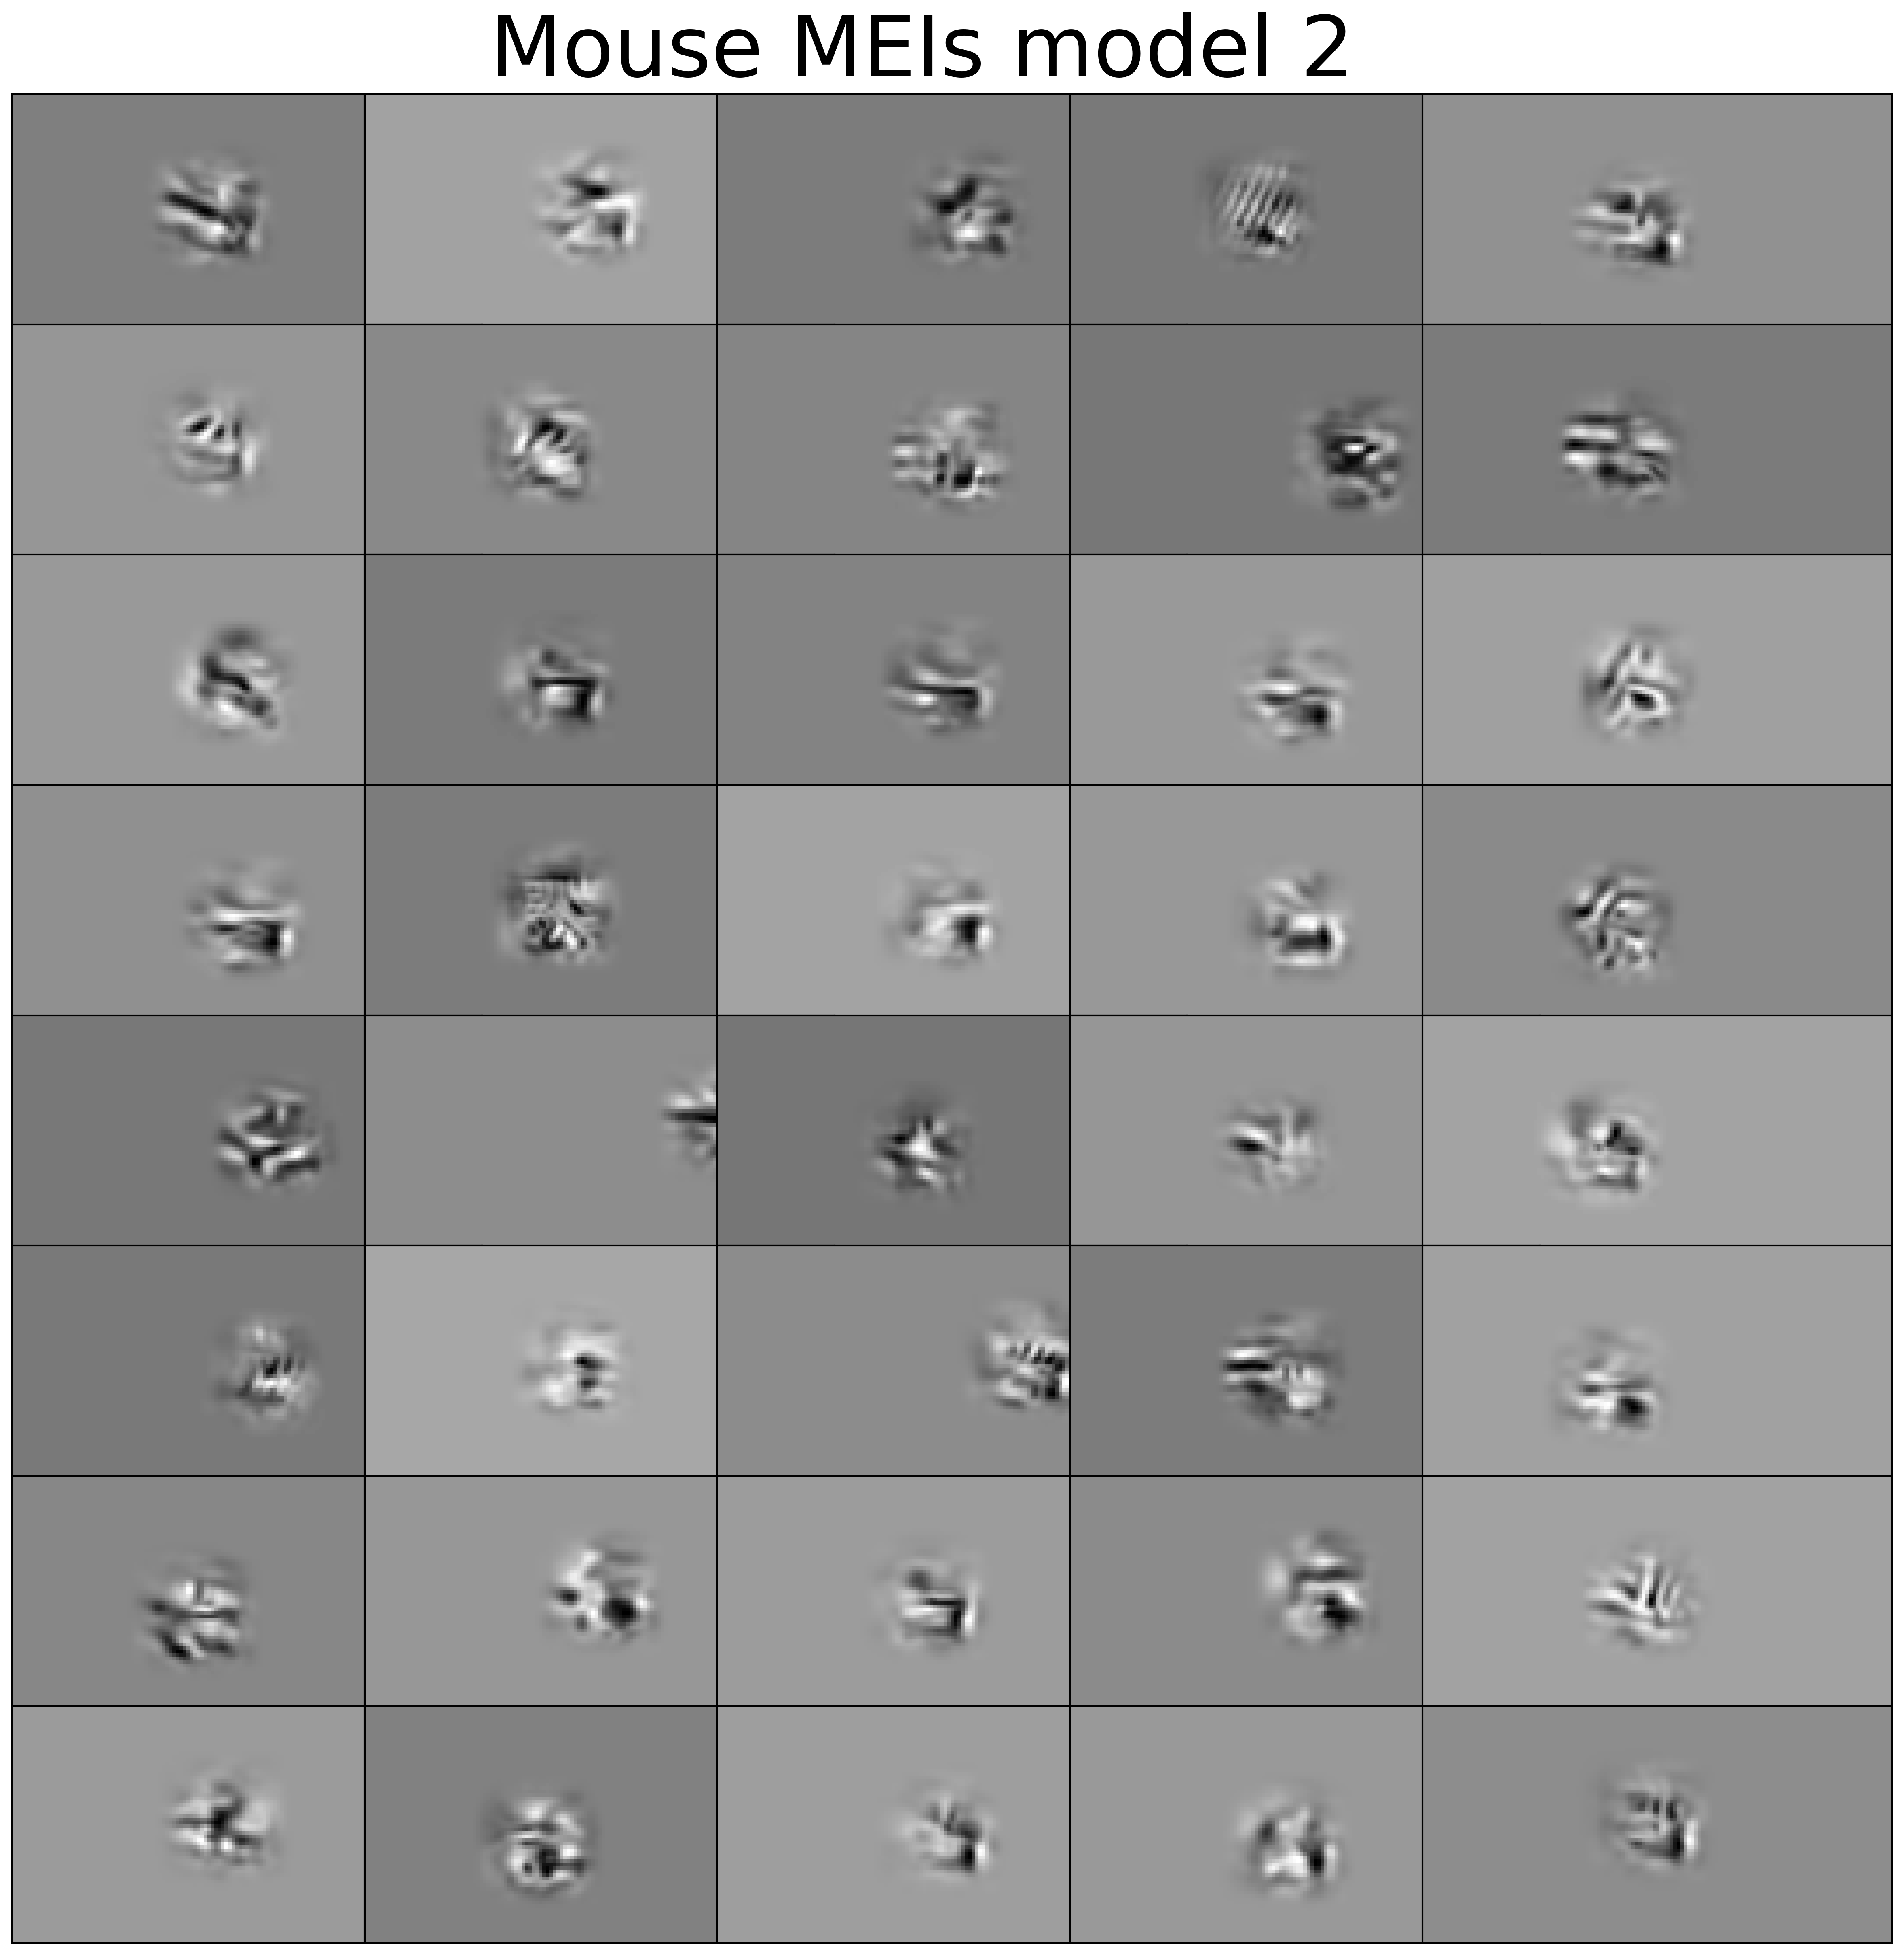

  0%|          | 0/8 [00:00<?, ?it/s]

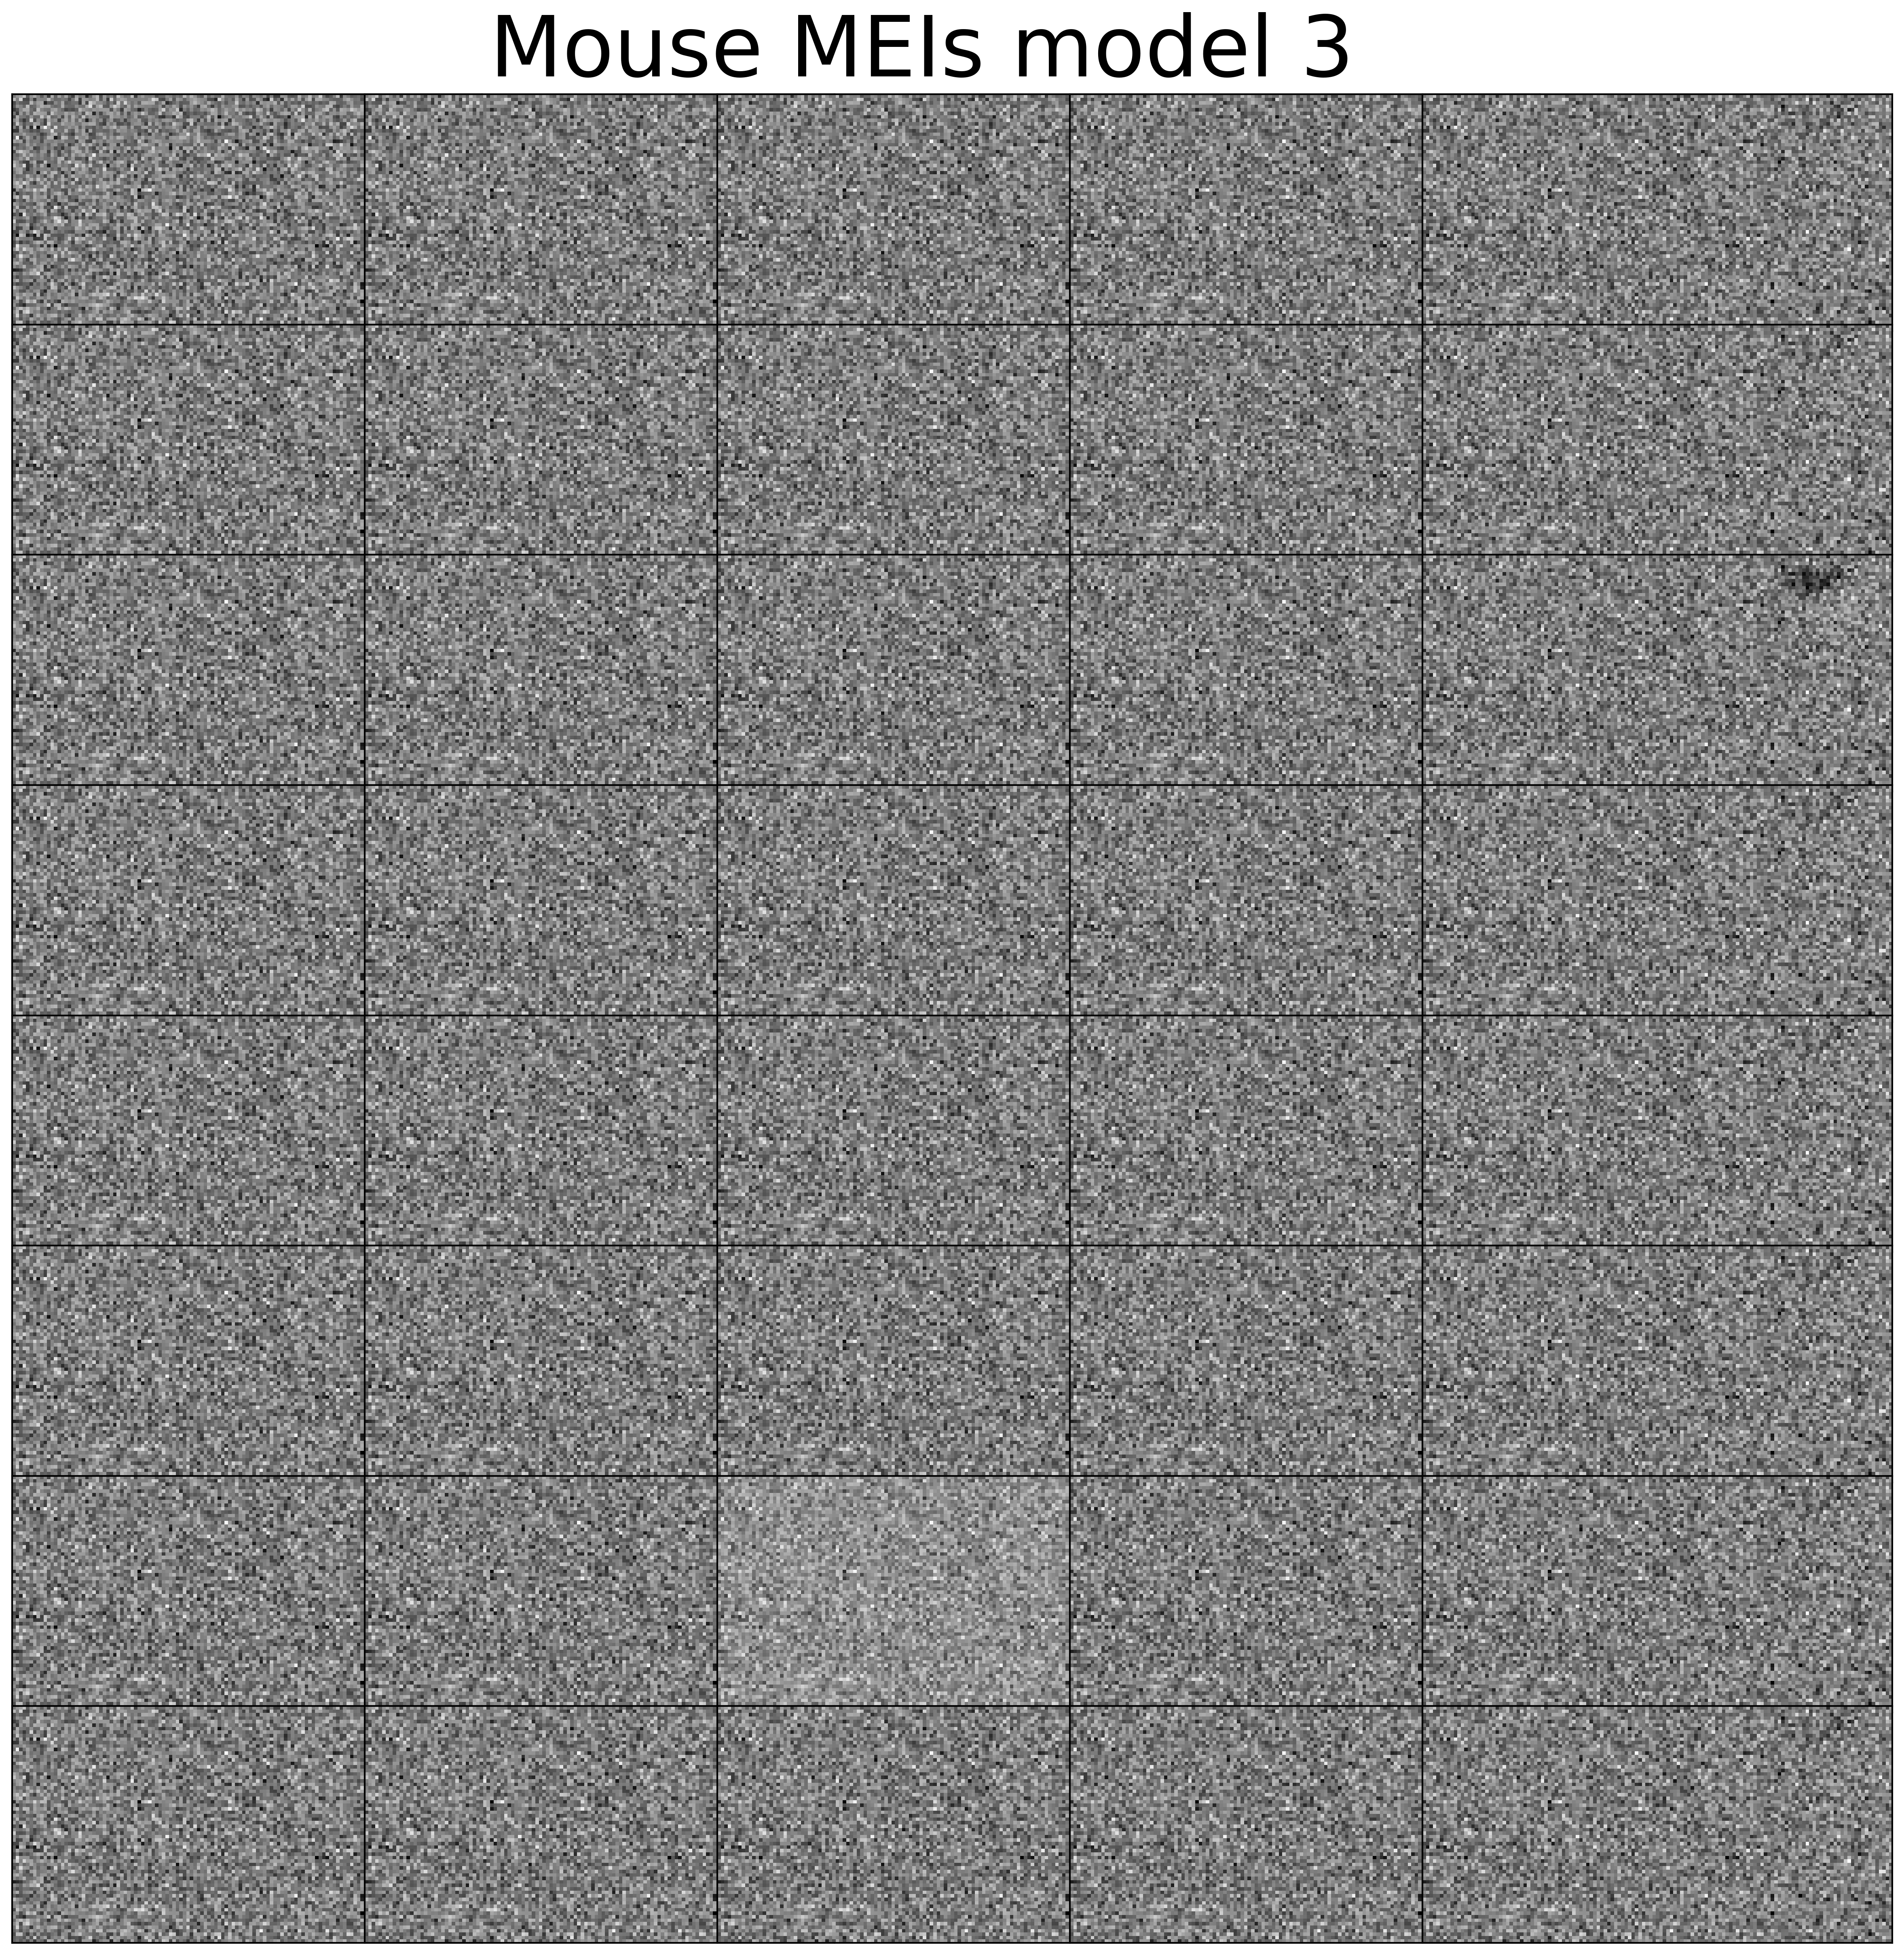

  0%|          | 0/8 [00:00<?, ?it/s]

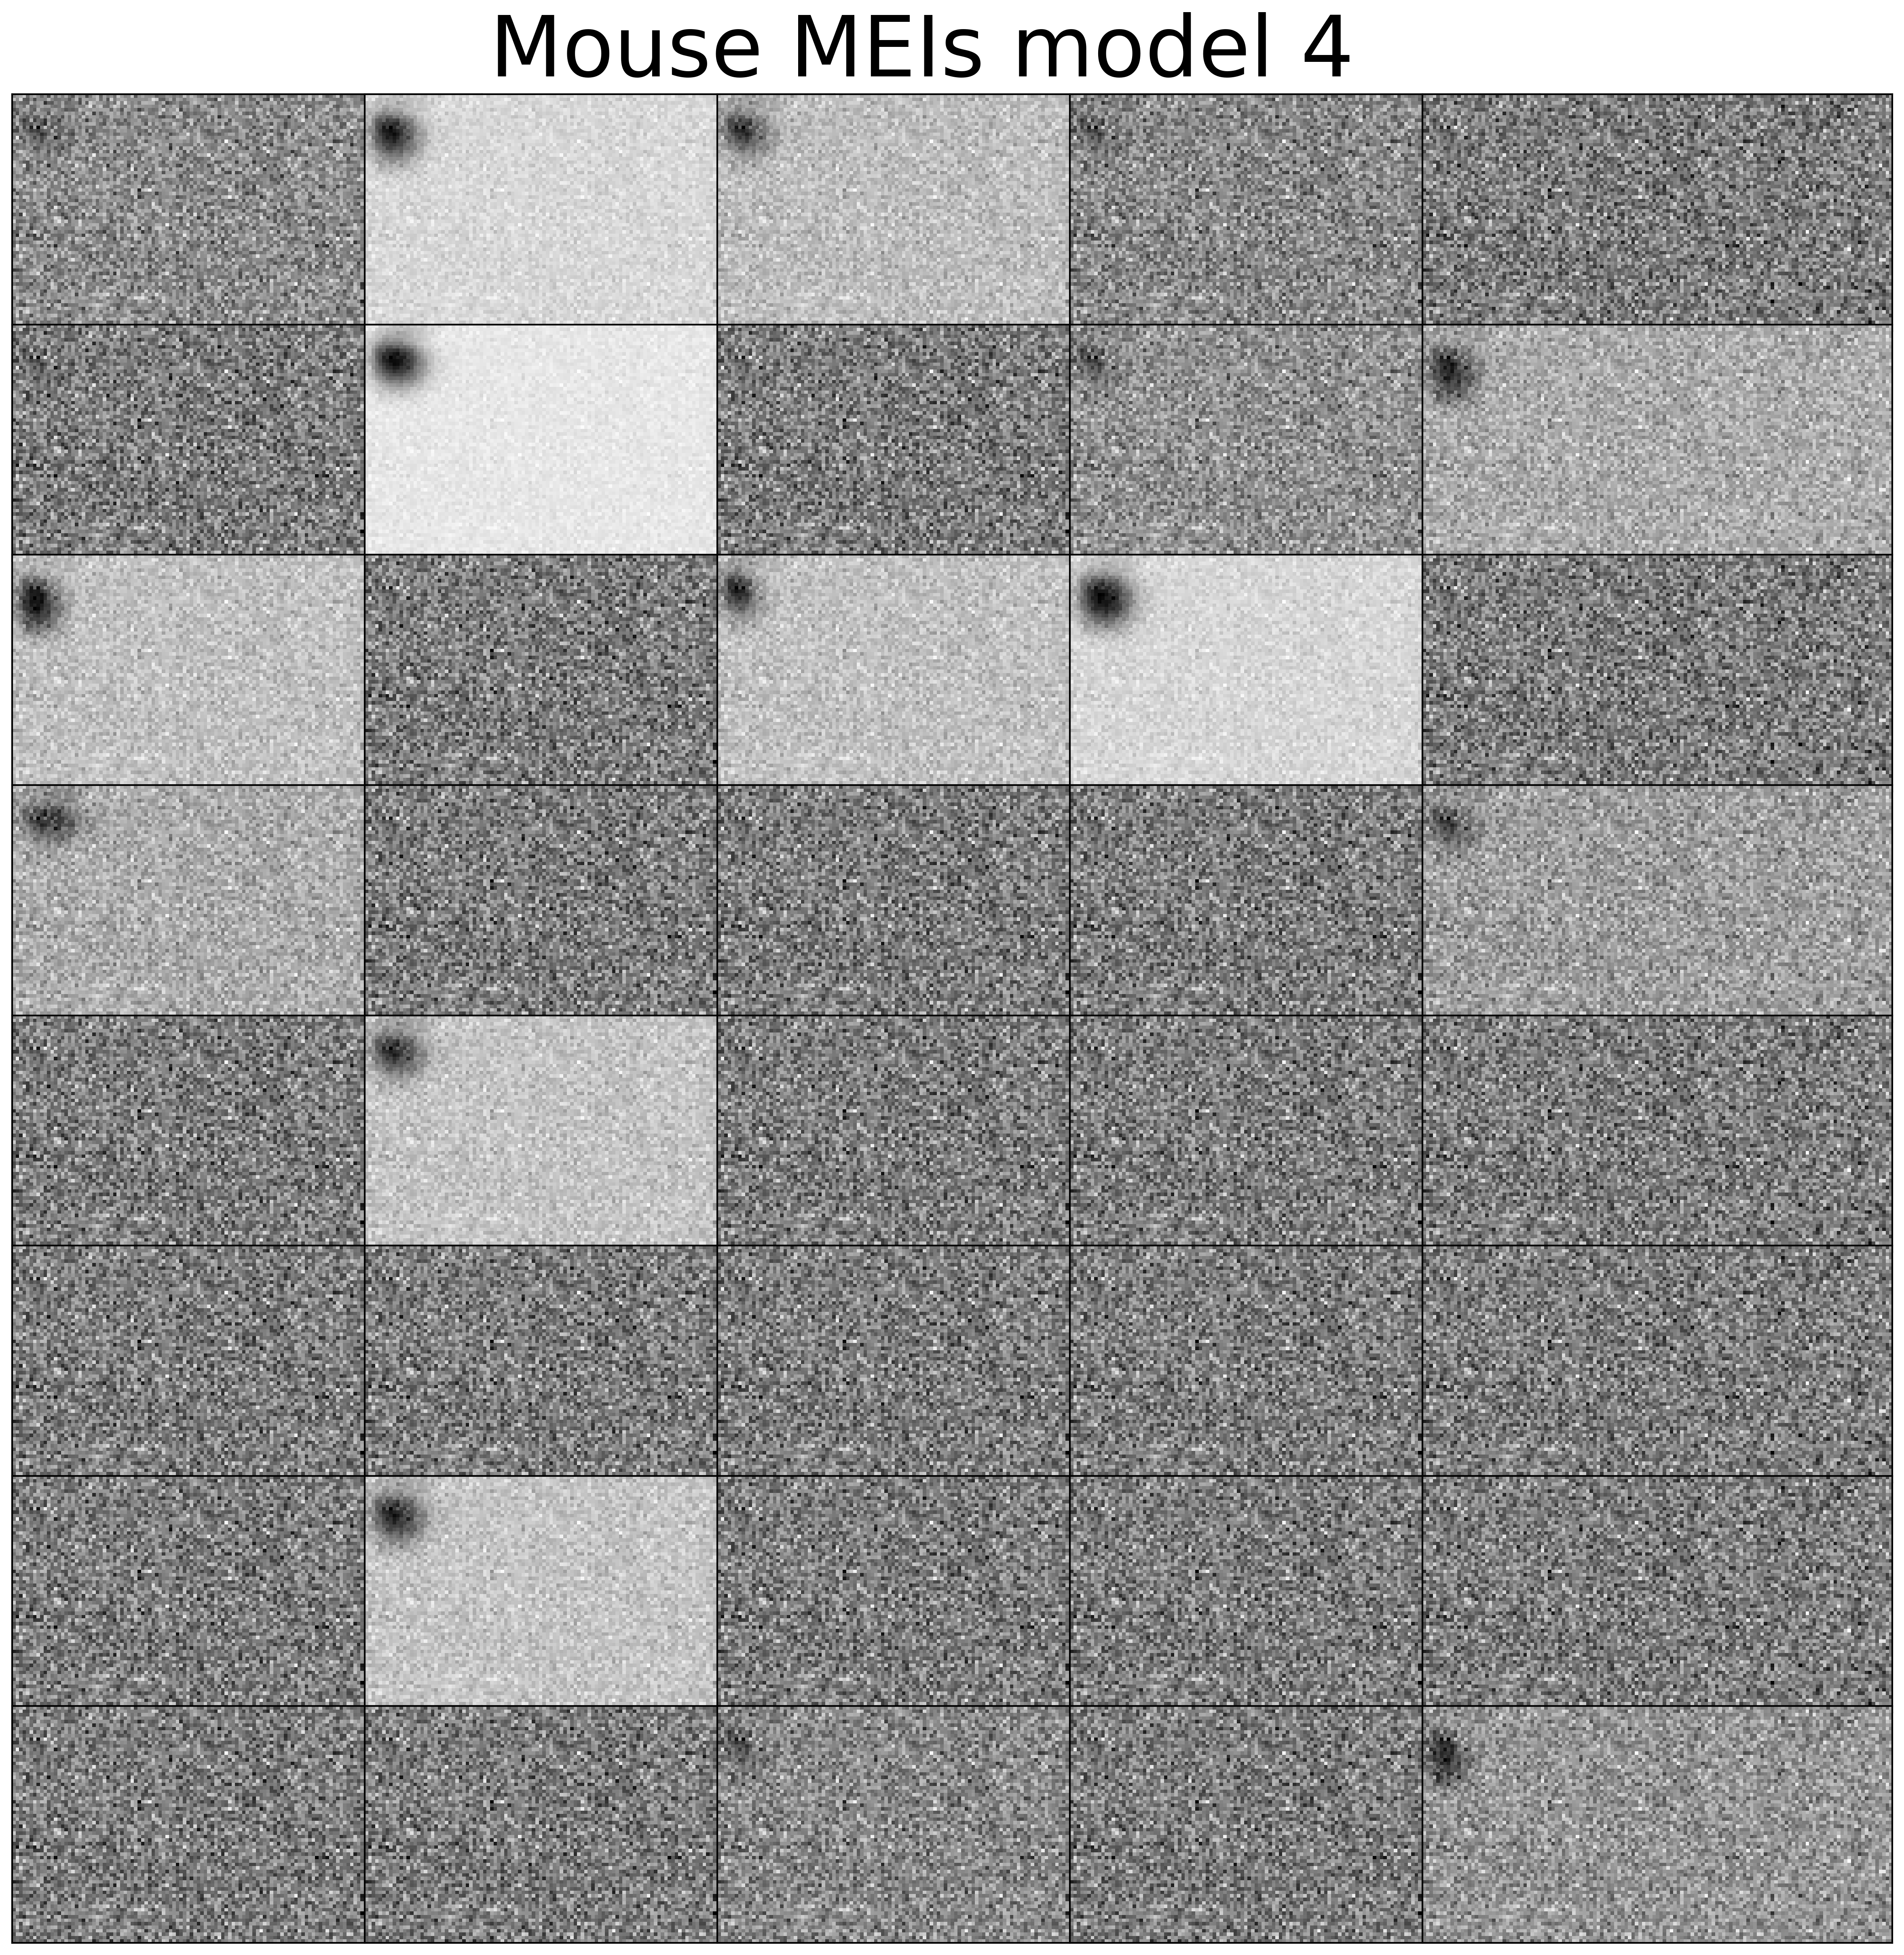

In [7]:

for k in range(num_models):
    # meis = torch.load(f"MEIs/meis_model_{k}.pth")
    meis = torch.load(f'{RUN_FOLDER}/meis_model_{k}.pth')
    fig, axes = plt.subplots(8,5, figsize=(20,20), dpi=300)
    fig.suptitle(f"Mouse MEIs model {k}", y=0.91, fontsize=50)
    for i in tqdm(range(8)):
        for j in range(5):
            index = i * 5 + j
            axes[i, j].imshow(meis[index].reshape(mei_generation_shape[1:])[0, :, :], cmap="gray")#, vmin=-1, vmax=1)
            axes[i, j].spines['top'].set_color('black')
            axes[i, j].spines['bottom'].set_color('black')
            axes[i, j].spines['left'].set_color('black')
            axes[i, j].spines['right'].set_color('black')
            axes[i, j].spines['top'].set_linewidth(1)
            axes[i, j].spines['bottom'].set_linewidth(1)
            axes[i, j].spines['left'].set_linewidth(1)
            axes[i, j].spines['right'].set_linewidth(1)
            axes[i, j].set_xticks([])
            axes[i, j].set_yticks([])
    plt.subplots_adjust(wspace=-0.25, hspace=-0.1)
    # os.makedirs("Plots", exist_ok=True)
    # plt.savefig(f"Plots/MouseMEIsTop200Model{k}.png", dpi=300)
    os.makedirs(f'{RUN_FOLDER}/Plots', exist_ok=True)
    # plt.savefig(f'{RUN_FOLDER}/Plots/MouseMEIsTop40Model{k}.png', dpi=300)
    plt.show()


In [30]:
import pickle

with open('runs/test_no_grid_mean_predictor/results/neuron_stats_LPE10885-LPE10885_2023_10_20-0.pkl', 'rb') as f:
    df = pickle.load(f)
df

{'mean': array([[ 0.96348238, -0.16504085],
        [-0.51223183,  0.15435605],
        [-0.00416788,  0.44176161],
        ...,
        [ 0.13872208,  0.43555751],
        [-0.73439175, -0.14833081],
        [ 0.88409024,  0.56251204]]),
 'cov': array([[[ 0.09511149, -0.03195108],
         [ 0.09334315,  0.01433618]],
 
        [[-0.00596362,  0.00260187],
         [ 0.00660815,  0.01437302]],
 
        [[-0.00380728, -0.0077743 ],
         [ 0.01897264, -0.0002598 ]],
 
        ...,
 
        [[-0.00073325,  0.00024952],
         [-0.01056526,  0.00237645]],
 
        [[ 0.00036238,  0.01182094],
         [ 0.02025543, -0.00616832]],
 
        [[-0.02365886,  0.00845251],
         [ 0.00315883,  0.06249369]]]),
 'jitter': array([[ 0.05096598, -0.04259183],
        [-0.02712329, -0.01809816],
        [-0.02309148, -0.01622564],
        ...,
        [-0.0351506 ,  0.01602343],
        [ 0.0370729 ,  0.0470336 ],
        [ 0.052     , -0.052     ]]),
 'loc': array([[ 1.01444836, -0.2076

In [33]:
import numpy as np

np.min(df['loc']), np.max(df['loc'])

(-1.0520000010728836, 1.0520000010728836)

In [157]:
import os
if 'notebooks' in os.getcwd():
    os.chdir('../..')  # change to main directory
if "adrian_sensorium" not in os.getcwd():
    os.chdir("adrian_sensorium")

print('Working directory:', os.getcwd())

Working directory: d:\Python\Anastasia\Petreanu Lab\adrian_sensorium


In [158]:
# %%capture
# !pip install -e ./lib/mei

In [159]:
os.getcwd()

'd:\\Python\\Anastasia\\Petreanu Lab\\adrian_sensorium'

## Restart Kernel after mei-module installation!

In [3]:
import torch
import numpy as np
import pandas as pd
import mei.legacy
import matplotlib.pyplot as plt
import seaborn as sns
import sensorium
import warnings
warnings.filterwarnings('ignore')
from tqdm.auto import tqdm
from nnfabrik.builder import get_data, get_model
from notebooks.submission_m4.gradient_ascent import gradient_ascent
from sensorium.utility import get_signal_correlations
from sensorium.utility.measure_helpers import get_df_for_scores

ModuleNotFoundError: No module named 'notebooks.submission_m4'

In [161]:
from sensorium.utility.training import read_config

In [162]:
seed=31415
# data_key_aut = "29027-6-17-1-6-5"
# data_key_wt = "29028-1-17-1-6-5"
# data_key_sens2 = "23964-4-22"
# autistic_mouse_dataPath = "../data/new_data2023/static29027-6-17-1-6-5-GrayImageNetFrame2-7bed7f7379d99271be5d144e5e59a8e7.zip"
# wildtype_mouse_dataPath = "../data/new_data2023/static29028-1-17-1-6-5-GrayImageNetFrame2-7bed7f7379d99271be5d144e5e59a8e7.zip"
# sens2_dataPath = "../data/sensorium_data2022/static23964-4-22-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"

In [163]:
# Loading config only for ensemble 0, because all 5 models have the same config (except
# for the seed and dataloader train/validation split)

config_file = 'notebooks/submission_m4/config_m4_ens0.yaml'
config = read_config(config_file)
print(config)

{'data_sets': ['all'], 'dataset_fn': 'sensorium.datasets.static_loaders', 'dataset_config': {'normalize': True, 'include_behavior': True, 'include_eye_position': True, 'batch_size': 128, 'scale': 0.25, 'preload_from_merged_data': True, 'include_trial_id': True, 'include_rank_id': True, 'include_history': True, 'include_behav_state': True, 'adjusted_normalization': True, 'use_ensemble_tier': True, 'ensemble_nr': 0}, 'model_fn': 'sensorium.models.modulated_stacked_core_full_gauss_readout', 'model_seed': 100, 'model_config': {'pad_input': False, 'stack': -1, 'layers': 4, 'input_kern': 9, 'gamma_input': 9.8, 'gamma_readout': 0.48, 'hidden_kern': 10, 'hidden_channels': 64, 'depth_separable': True, 'grid_mean_predictor': {'type': 'cortex', 'input_dimensions': 2, 'hidden_layers': 4, 'hidden_features': 20, 'nonlinearity': 'ReLU', 'final_tanh': True}, 'init_sigma': 0.14, 'init_mu_range': 0.8, 'gauss_type': 'full', 'shifter': True, 'with_modulator': True, 'modulator_type': 'HistoryStateGain', 'm

In [164]:
# Use only one dataloader, since test and final_test are the same for all ensembles
# basepath = "notebooks/data/"
# filenames = [os.path.join(basepath, file) for file in os.listdir(basepath) if ".zip" in file ]
# filenames = [file for file in filenames if 'static26872-17-20' not in file]

basepath = "notebooks/data/IM_prezipped"
# Add Add folders two levels deep from basepath into a list
# First level
folders = [os.path.join(basepath, name) for name in os.listdir(
    basepath) if os.path.isdir(os.path.join(basepath, name)) and not "merged_data" in name]
# Second level
folders = [os.path.join(folder, name) for folder in folders for name in os.listdir(
    folder) if os.path.isdir(os.path.join(folder, name)) and not "merged_data" in name]
folders = [x.replace("\\", "/") for x in folders]
folders

['notebooks/data/IM_prezipped/LPE10885/2023_10_20']

In [165]:
# dataset_fn = 'sensorium.datasets.static_loaders'

# filenames_autistic = [autistic_mouse_dataPath, ]

# dataset_config_autistic = {'paths': filenames_autistic,
#                  'normalize': True,
#                  'include_behavior': False,
#                  'include_eye_position': False,
#                  'batch_size': 128,
#                  'scale':1,
#                  }

# dataloaders_autistic = get_data(dataset_fn, dataset_config_autistic)

# filenames_wildtype = [wildtype_mouse_dataPath, ]

# dataset_config_wildtype = {'paths': filenames_wildtype,
#                  'normalize': True,
#                  'include_behavior': False,
#                  'include_eye_position': False,
#                  'batch_size': 128,
#                  'scale':1,
#                  }

# dataloaders_wildtype = get_data(dataset_fn, dataset_config_wildtype)

# filenames_sens2 = [sens2_dataPath, ]

# dataset_config_sens2 = {'paths': filenames_sens2,
#                  'normalize': True,
#                  'include_behavior': False,
#                  'include_eye_position': False,
#                  'batch_size': 128,
#                  'scale':0.25,
#                  }

# dataloaders_sens2 = get_data(dataset_fn, dataset_config_sens2)

In [166]:
dataset_fn = config['dataset_fn']  # 'sensorium.datasets.static_loaders'
dataset_config = {'paths': folders,  # filenames,
                  **config['dataset_config'],
                  }

dataloaders = get_data(dataset_fn, dataset_config)

In [167]:
# model_fn = 'sensorium.models.stacked_core_full_gauss_readout'
# model_config = {'pad_input': False,
#   'stack': -1,
#   'layers': 4,
#   'input_kern': 9,
#   'gamma_input': 6.3831,
#   'gamma_readout': 0.0076,
#   'hidden_kern': 7,
#   'hidden_channels': 64,
#   'depth_separable': True,
#   'grid_mean_predictor': {'type': 'cortex',
#    'input_dimensions': 2,
#    'hidden_layers': 1,
#    'hidden_features': 30,
#    'final_tanh': True},
#   'init_sigma': 0.1,
#   'init_mu_range': 0.3,
#   'gauss_type': 'full',
#   'shifter': False,
# }

# model_a = get_model(model_fn=model_fn,
#                   model_config=model_config,
#                   dataloaders=dataloaders_autistic,
#                   seed=seed,
#                   )
# model_wt = get_model(model_fn=model_fn,
#                   model_config=model_config,
#                   dataloaders=dataloaders_wildtype,
#                   seed=seed,
#                   )

# model_sens2= get_model(model_fn=model_fn,
#                   model_config=model_config,
#                   dataloaders=dataloaders_sens2,
#                   seed=seed,
#                   )

In [168]:
# Instantiate all five models
model_list = list()

for i in tqdm(range(5)):
    # all models have the same parameters
    # e.g. 'sensorium.models.modulated_stacked_core_full_gauss_readout'
    model_fn = config['model_fn']
    model_config = config['model_config']

    model = get_model(model_fn=model_fn,
                      model_config=model_config,
                      dataloaders=dataloaders,
                      seed=config['model_seed'],
                      )

    # Load trained weights from specific ensemble
    save_file = 'saved_models/config_m4_ens{}/saved_model_v1.pth'.format(i)
    model.load_state_dict(torch.load(save_file))
    model_list.append(model)

  0%|          | 0/5 [00:00<?, ?it/s]

In [169]:
# model_a.load_state_dict(torch.load("./model_checkpoints/autistic_model.pth"))
# model_wt.load_state_dict(torch.load("./model_checkpoints/wildtype_model.pth"))
# model_sens2.load_state_dict(torch.load("./model_checkpoints/sensorium23964-4-22.pth"))

In [170]:
# model_a.eval()
# model_wt.eval()
# model_sens2.eval()

In [171]:
# correlation_to_average_a = get_signal_correlations(model_a, dataloaders_autistic, tier="test", device="cuda", as_dict=True)
# correlation_to_average_wt = get_signal_correlations(model_wt, dataloaders_wildtype, tier="test", device="cuda", as_dict=True)
# correlation_to_average_s2 = get_signal_correlations(model_sens2, dataloaders_sens2, tier="test", device="cuda", as_dict=True)

# df_cta_a = get_df_for_scores(session_dict=correlation_to_average_a, measure_attribute="Correlation to Average")
# df_cta_wt = get_df_for_scores(session_dict=correlation_to_average_wt, measure_attribute="Correlation to Average")
# df_cta_s2 = get_df_for_scores(session_dict=correlation_to_average_s2, measure_attribute="Correlation to Average")

In [172]:
# top200units_a = df_cta_a.sort_values(["Correlation to Average"], ascending=False).reset_index()[:200]["index"].to_list()
# top200units_wt = df_cta_wt.sort_values(["Correlation to Average"], ascending=False).reset_index()[:200]["index"].to_list()
# top200units_s2 = df_cta_s2.sort_values(["Correlation to Average"], ascending=False).reset_index()[:200]["index"].to_list()

In [173]:
from sensorium.models.ensemble import EnsemblePrediction
ensemble = EnsemblePrediction(model_list, mode='mean')

In [174]:
correlation_to_average = get_signal_correlations(ensemble, dataloaders, tier='test', device='cuda', as_dict=True)

df_cta = get_df_for_scores(session_dict=correlation_to_average, measure_attribute="Correlation to Average")

In [175]:
data_key = 'LPE10885-LPE10885_2023_10_20-0'

config_mei = dict(
    initial={"path": "mei.initial.RandomNormal"},
    optimizer={"path": "torch.optim.SGD", "kwargs": {"lr": 1}},
    # transform={"path": "C:\\Users\\asimo\\Documents\\BCCN\\Lab Rotations\\Petreanu Lab\\adrian_sensorium\\notebooks\\submission_m4\\transform.only_keep_1st_dimension"},
    # transform={"path": "transform.only_keep_1st_dimension", "kwargs": {"mei": torch.zeros(1, 4, 64, 64), "i_iteration": 0}},
    # transform={"path": "transform.only_keep_1st_dimension"},#, "kwargs": {"mei": torch.zeros(1, 4, 64, 64), "i_iteration": 0}},
    transform={"path": "notebooks.submission_m4.transform.OnlyKeep1stDimension"},# "kwargs": {"mei": None, "i_iteration": None}},
    precondition={"path": "mei.legacy.ops.GaussianBlur", "kwargs": {"sigma": 1}},
    postprocessing={"path": "mei.legacy.ops.ChangeNorm", "kwargs": {"norm": 7.5}},
    transparency_weight=0.0,
    stopper={"path": "mei.stoppers.NumIterations", "kwargs": {"num_iterations": 1000}},
    objectives=[
        {"path": "mei.objectives.EvaluationObjective", "kwargs": {"interval": 10}}
    ],
    device="cuda"
)

In [176]:
df_cta = df_cta.loc[df_cta['dataset'] == data_key].reset_index(drop=True)

top200units = df_cta.sort_values(['Correlation to Average'], ascending=False).reset_index()[:200]['index'].to_list()
top40units = df_cta.sort_values(['Correlation to Average'], ascending=False).reset_index()[:40]['index'].to_list()

In [177]:
ensemble = ensemble.eval()

In [179]:
meis = []
for i in tqdm(top200units):
    mei_out, _, _ = gradient_ascent(ensemble, config_mei, data_key=data_key, unit=i, seed=seed, shape=(1, 4, 68, 135)) # need to pass all dimensions, but all except the first 1 are set to 0 in the transform
    meis.append(mei_out)
torch.save(meis, "MEIs/meis.pth")

  0%|          | 0/200 [00:00<?, ?it/s]

Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency

In [180]:
for i, model in enumerate(model_list):
    model = model.eval()
    model_list[i] = model

In [181]:
for model_idx, model in enumerate(model_list):
    print(f"Model {model_idx}")
    meis = []
    for i in tqdm(top40units):
        mei_out, _, _ = gradient_ascent(model, config_mei, data_key=data_key, unit=i, seed=seed, shape=(1, 4, 68, 135)) # need to pass all dimensions, but all except the first 1 are set to 0 in the transform
        meis.append(mei_out)
    torch.save(meis, f"MEIs/meis_model_{model_idx}.pth")

Model 0


  0%|          | 0/40 [00:00<?, ?it/s]

Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency

  0%|          | 0/40 [00:00<?, ?it/s]

Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency

  0%|          | 0/40 [00:00<?, ?it/s]

Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency

  0%|          | 0/40 [00:00<?, ?it/s]

Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency

  0%|          | 0/40 [00:00<?, ?it/s]

Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency weight of 0.0
Using a transparency

In [182]:
# meis_a = []
# for i in tqdm(top200units_a):
#     mei_a, _, _ = gradient_ascent(model_a, config_mei, data_key=data_key_aut, unit=i, seed=seed, shape=(1,1,36,64))
#     meis_a.append(mei_a)
# torch.save(meis_a, "MEIs/meis_a200.pt")

In [183]:
# meis_wt = []
# for i in tqdm(top200units_wt):
#     mei_wt, _, _ = gradient_ascent(model_wt, config, data_key=data_key_wt, unit=i, seed=seed, shape=(1,1,36,64))
#     meis_wt.append(mei_wt)
# torch.save(meis_wt, "MEIs/meis_wt200.pt")

In [184]:
# meis_s2 = []

# for i in tqdm(top200units_s2):
#     mei_s2, _, _ = gradient_ascent(model_sens2, config, data_key=data_key_sens2, unit=i, seed=seed, shape=(1,1,36,64))
#     meis_s2.append(mei_s2)
# torch.save(meis_s2, "MEIs/meis_s200.pt")

In [185]:
# meis_a = torch.load("MEIs/meis_a200.pt")
# meis_wt = torch.load("MEIs/meis_wt200.pt")

In [186]:
# meis = torch.load("MEIs/meis.pth")

  0%|          | 0/8 [00:00<?, ?it/s]

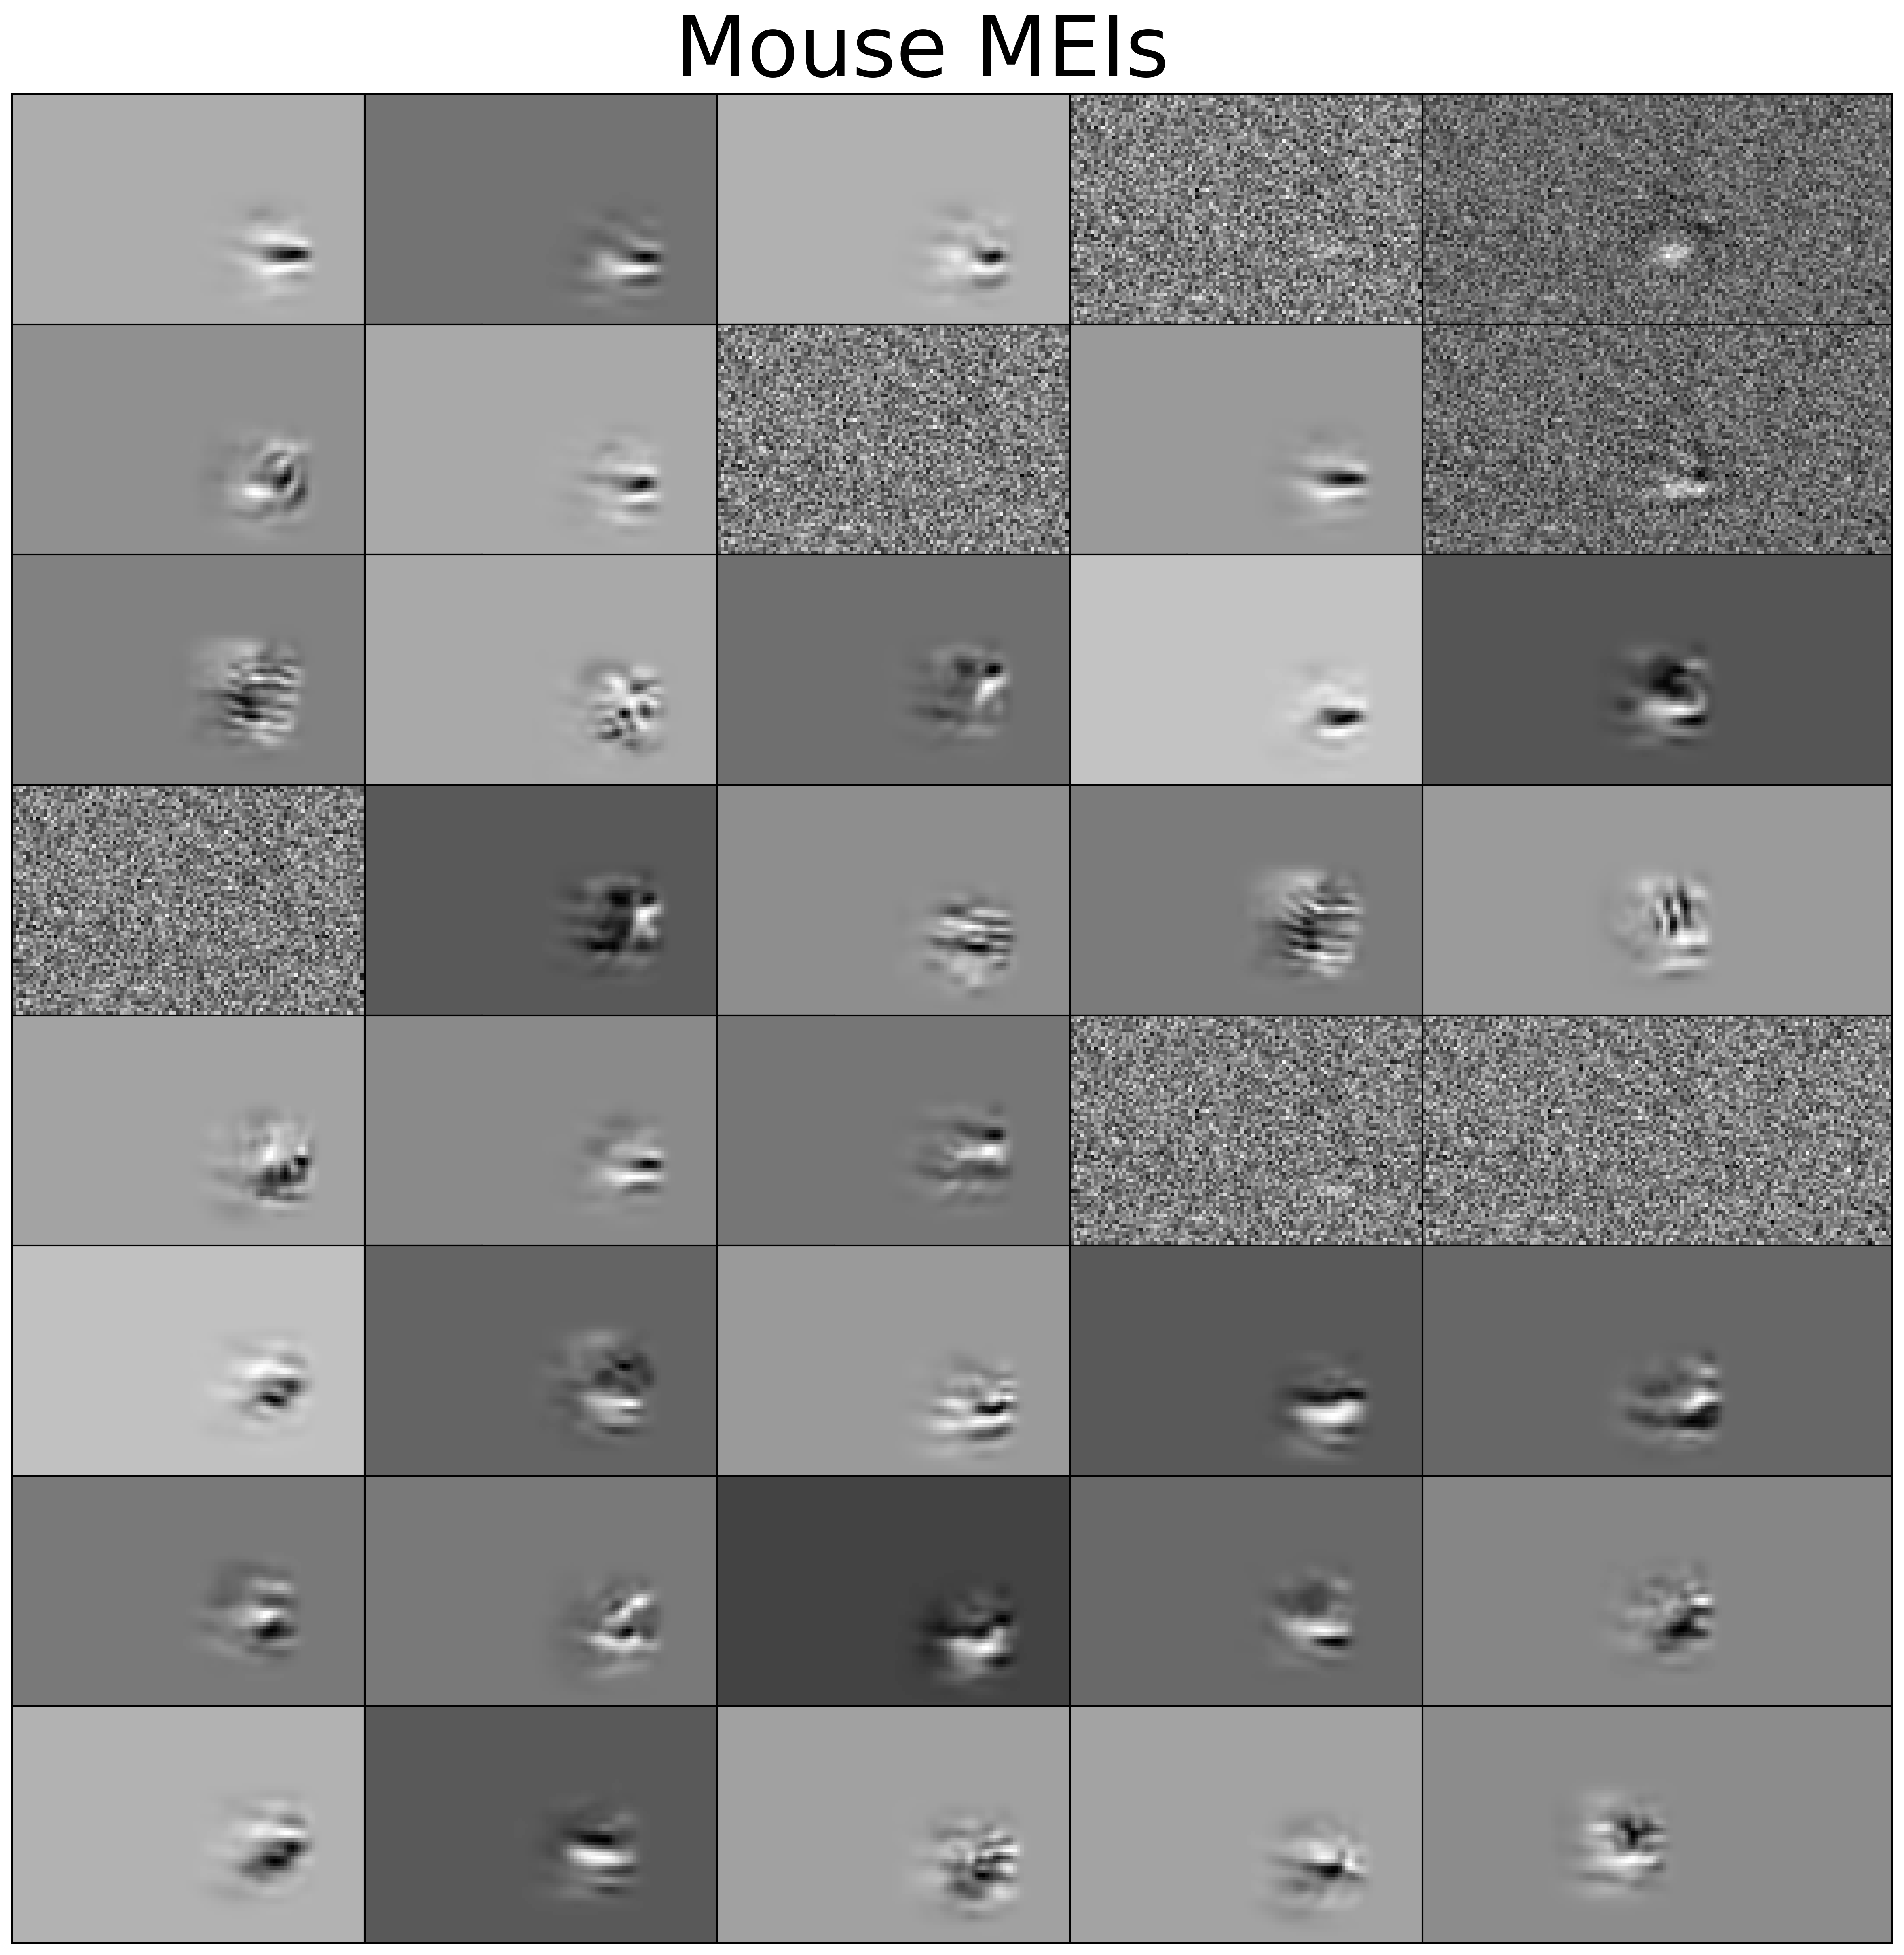

In [187]:
fig, axes = plt.subplots(8,5, figsize=(20,20), dpi=300)
fig.suptitle("Mouse MEIs", y=0.91, fontsize=50)
for i in tqdm(range(8)):
    for j in range(5):
        index = i * 5 + j
        # axes[i, j].imshow(meis[index].reshape(4, 64, 96).mean(0), cmap="gray")#, vmin=-1, vmax=1)
        axes[i, j].imshow(meis[index][0, 0, ...], cmap="gray")#, vmin=-1, vmax=1)
        axes[i, j].spines['top'].set_color('black')
        axes[i, j].spines['bottom'].set_color('black')
        axes[i, j].spines['left'].set_color('black')
        axes[i, j].spines['right'].set_color('black')
        axes[i, j].spines['top'].set_linewidth(1)
        axes[i, j].spines['bottom'].set_linewidth(1)
        axes[i, j].spines['left'].set_linewidth(1)
        axes[i, j].spines['right'].set_linewidth(1)
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
plt.subplots_adjust(wspace=-0.25, hspace=-0.1)
os.makedirs("Plots", exist_ok=True)
plt.savefig("Plots/MouseMEIsTop200.png", dpi=300)
plt.show()

In [188]:
# for k in range(4):
#     fig, axes = plt.subplots(20,10, figsize=(20,20), dpi=300)
#     fig.suptitle(f"Mouse MEIs Channel {k}", y=0.91, fontsize=50)
#     for i in tqdm(range(20)):
#         for j in range(10):
#             index = i * 10 + j
#             axes[i, j].imshow(meis[index].reshape(4, 64, 96)[k, :, :], cmap="gray")#, vmin=-1, vmax=1)
#             axes[i, j].spines['top'].set_color('black')
#             axes[i, j].spines['bottom'].set_color('black')
#             axes[i, j].spines['left'].set_color('black')
#             axes[i, j].spines['right'].set_color('black')
#             axes[i, j].spines['top'].set_linewidth(1)
#             axes[i, j].spines['bottom'].set_linewidth(1)
#             axes[i, j].spines['left'].set_linewidth(1)
#             axes[i, j].spines['right'].set_linewidth(1)
#             axes[i, j].set_xticks([])
#             axes[i, j].set_yticks([])
#     plt.subplots_adjust(wspace=-0.25, hspace=-0.1)
#     os.makedirs("Plots", exist_ok=True)
#     plt.savefig(f"Plots/MouseMEIsTop200Channel{k}.png", dpi=300)
#     plt.show()

  0%|          | 0/8 [00:00<?, ?it/s]

RuntimeError: shape '[4, 64, 96]' is invalid for input of size 36720

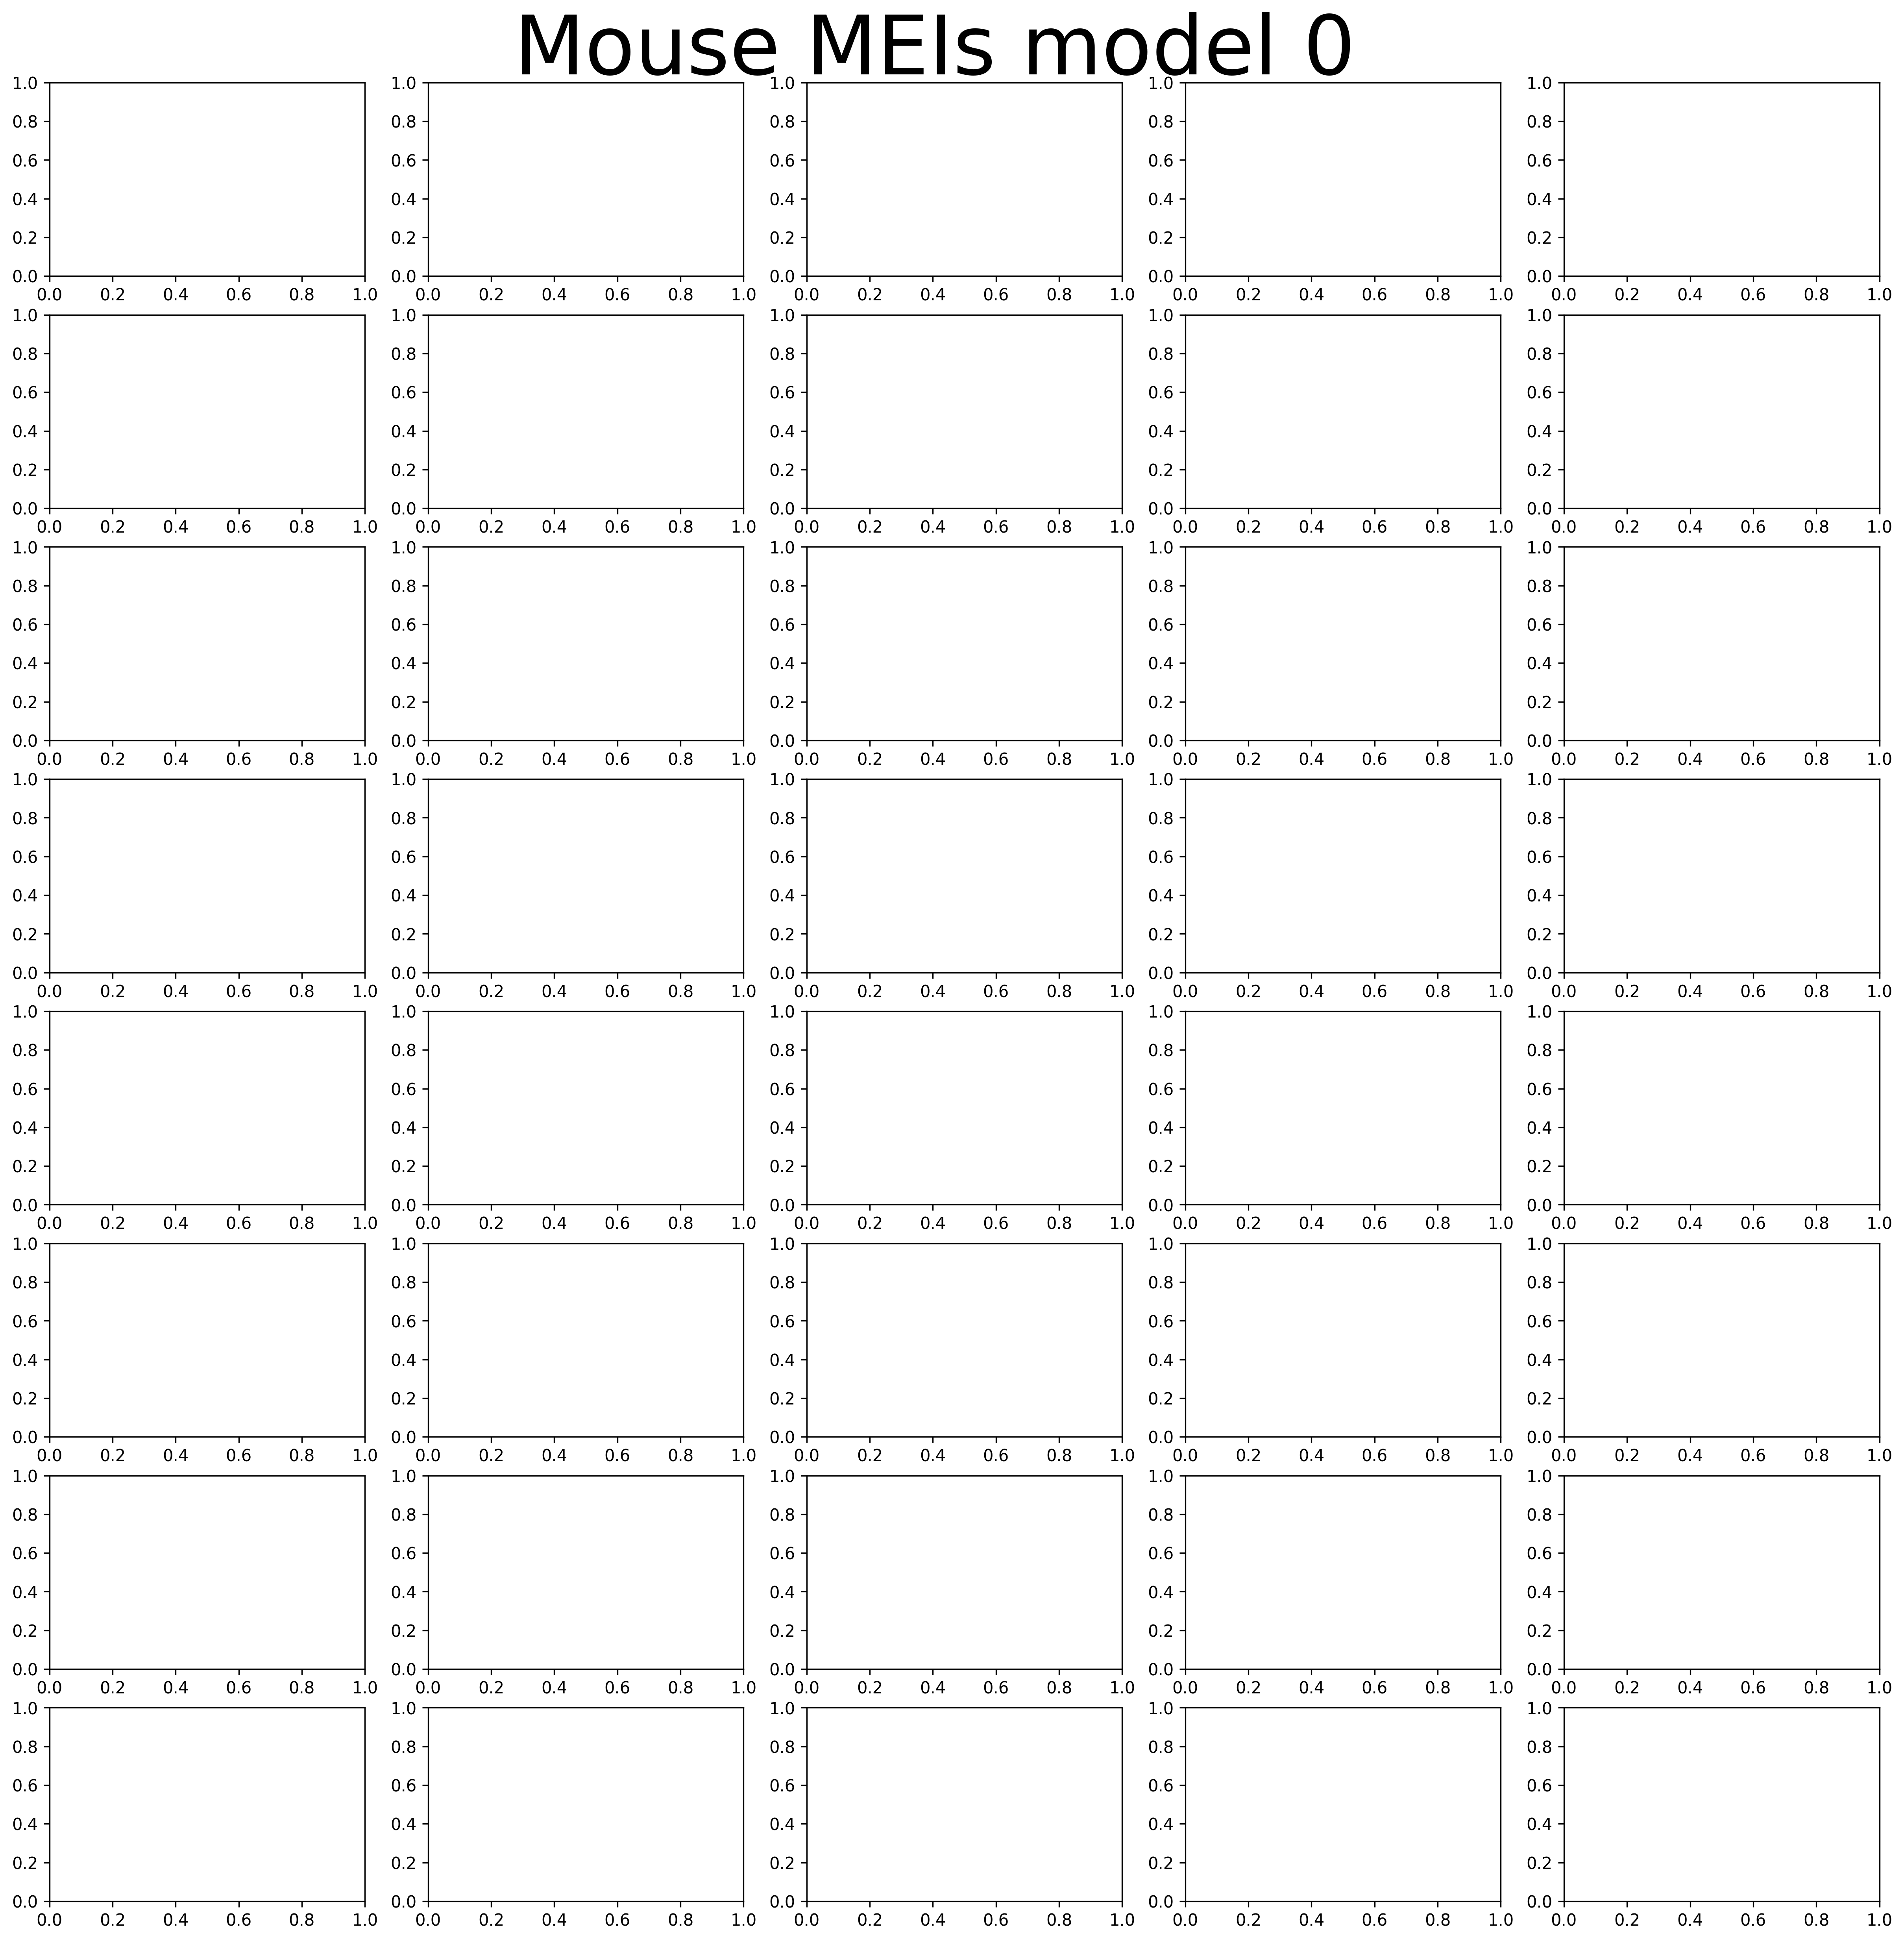

In [189]:
for k in range(5):
    meis = torch.load(f"MEIs/meis_model_{k}.pth")
    fig, axes = plt.subplots(8,5, figsize=(20,20), dpi=300)
    fig.suptitle(f"Mouse MEIs model {k}", y=0.91, fontsize=50)
    for i in tqdm(range(8)):
        for j in range(5):
            index = i * 5 + j
            axes[i, j].imshow(meis[index].reshape(4, 64, 96)[0, :, :], cmap="gray")#, vmin=-1, vmax=1)
            axes[i, j].spines['top'].set_color('black')
            axes[i, j].spines['bottom'].set_color('black')
            axes[i, j].spines['left'].set_color('black')
            axes[i, j].spines['right'].set_color('black')
            axes[i, j].spines['top'].set_linewidth(1)
            axes[i, j].spines['bottom'].set_linewidth(1)
            axes[i, j].spines['left'].set_linewidth(1)
            axes[i, j].spines['right'].set_linewidth(1)
            axes[i, j].set_xticks([])
            axes[i, j].set_yticks([])
    plt.subplots_adjust(wspace=-0.25, hspace=-0.1)
    os.makedirs("Plots", exist_ok=True)
    plt.savefig(f"Plots/MouseMEIsTop200Model{k}.png", dpi=300)
    plt.show()

In [103]:
meis_list = []

for i in range(5):
    meis_list.append(torch.load(f"MEIs/meis_model_{i}.pth"))

meis_list = [torch.stack(meis, dim=0) for meis in meis_list]
meis_list = torch.stack(meis_list, dim=0)

avg_meis = meis_list.mean(dim=0)

  0%|          | 0/8 [00:00<?, ?it/s]

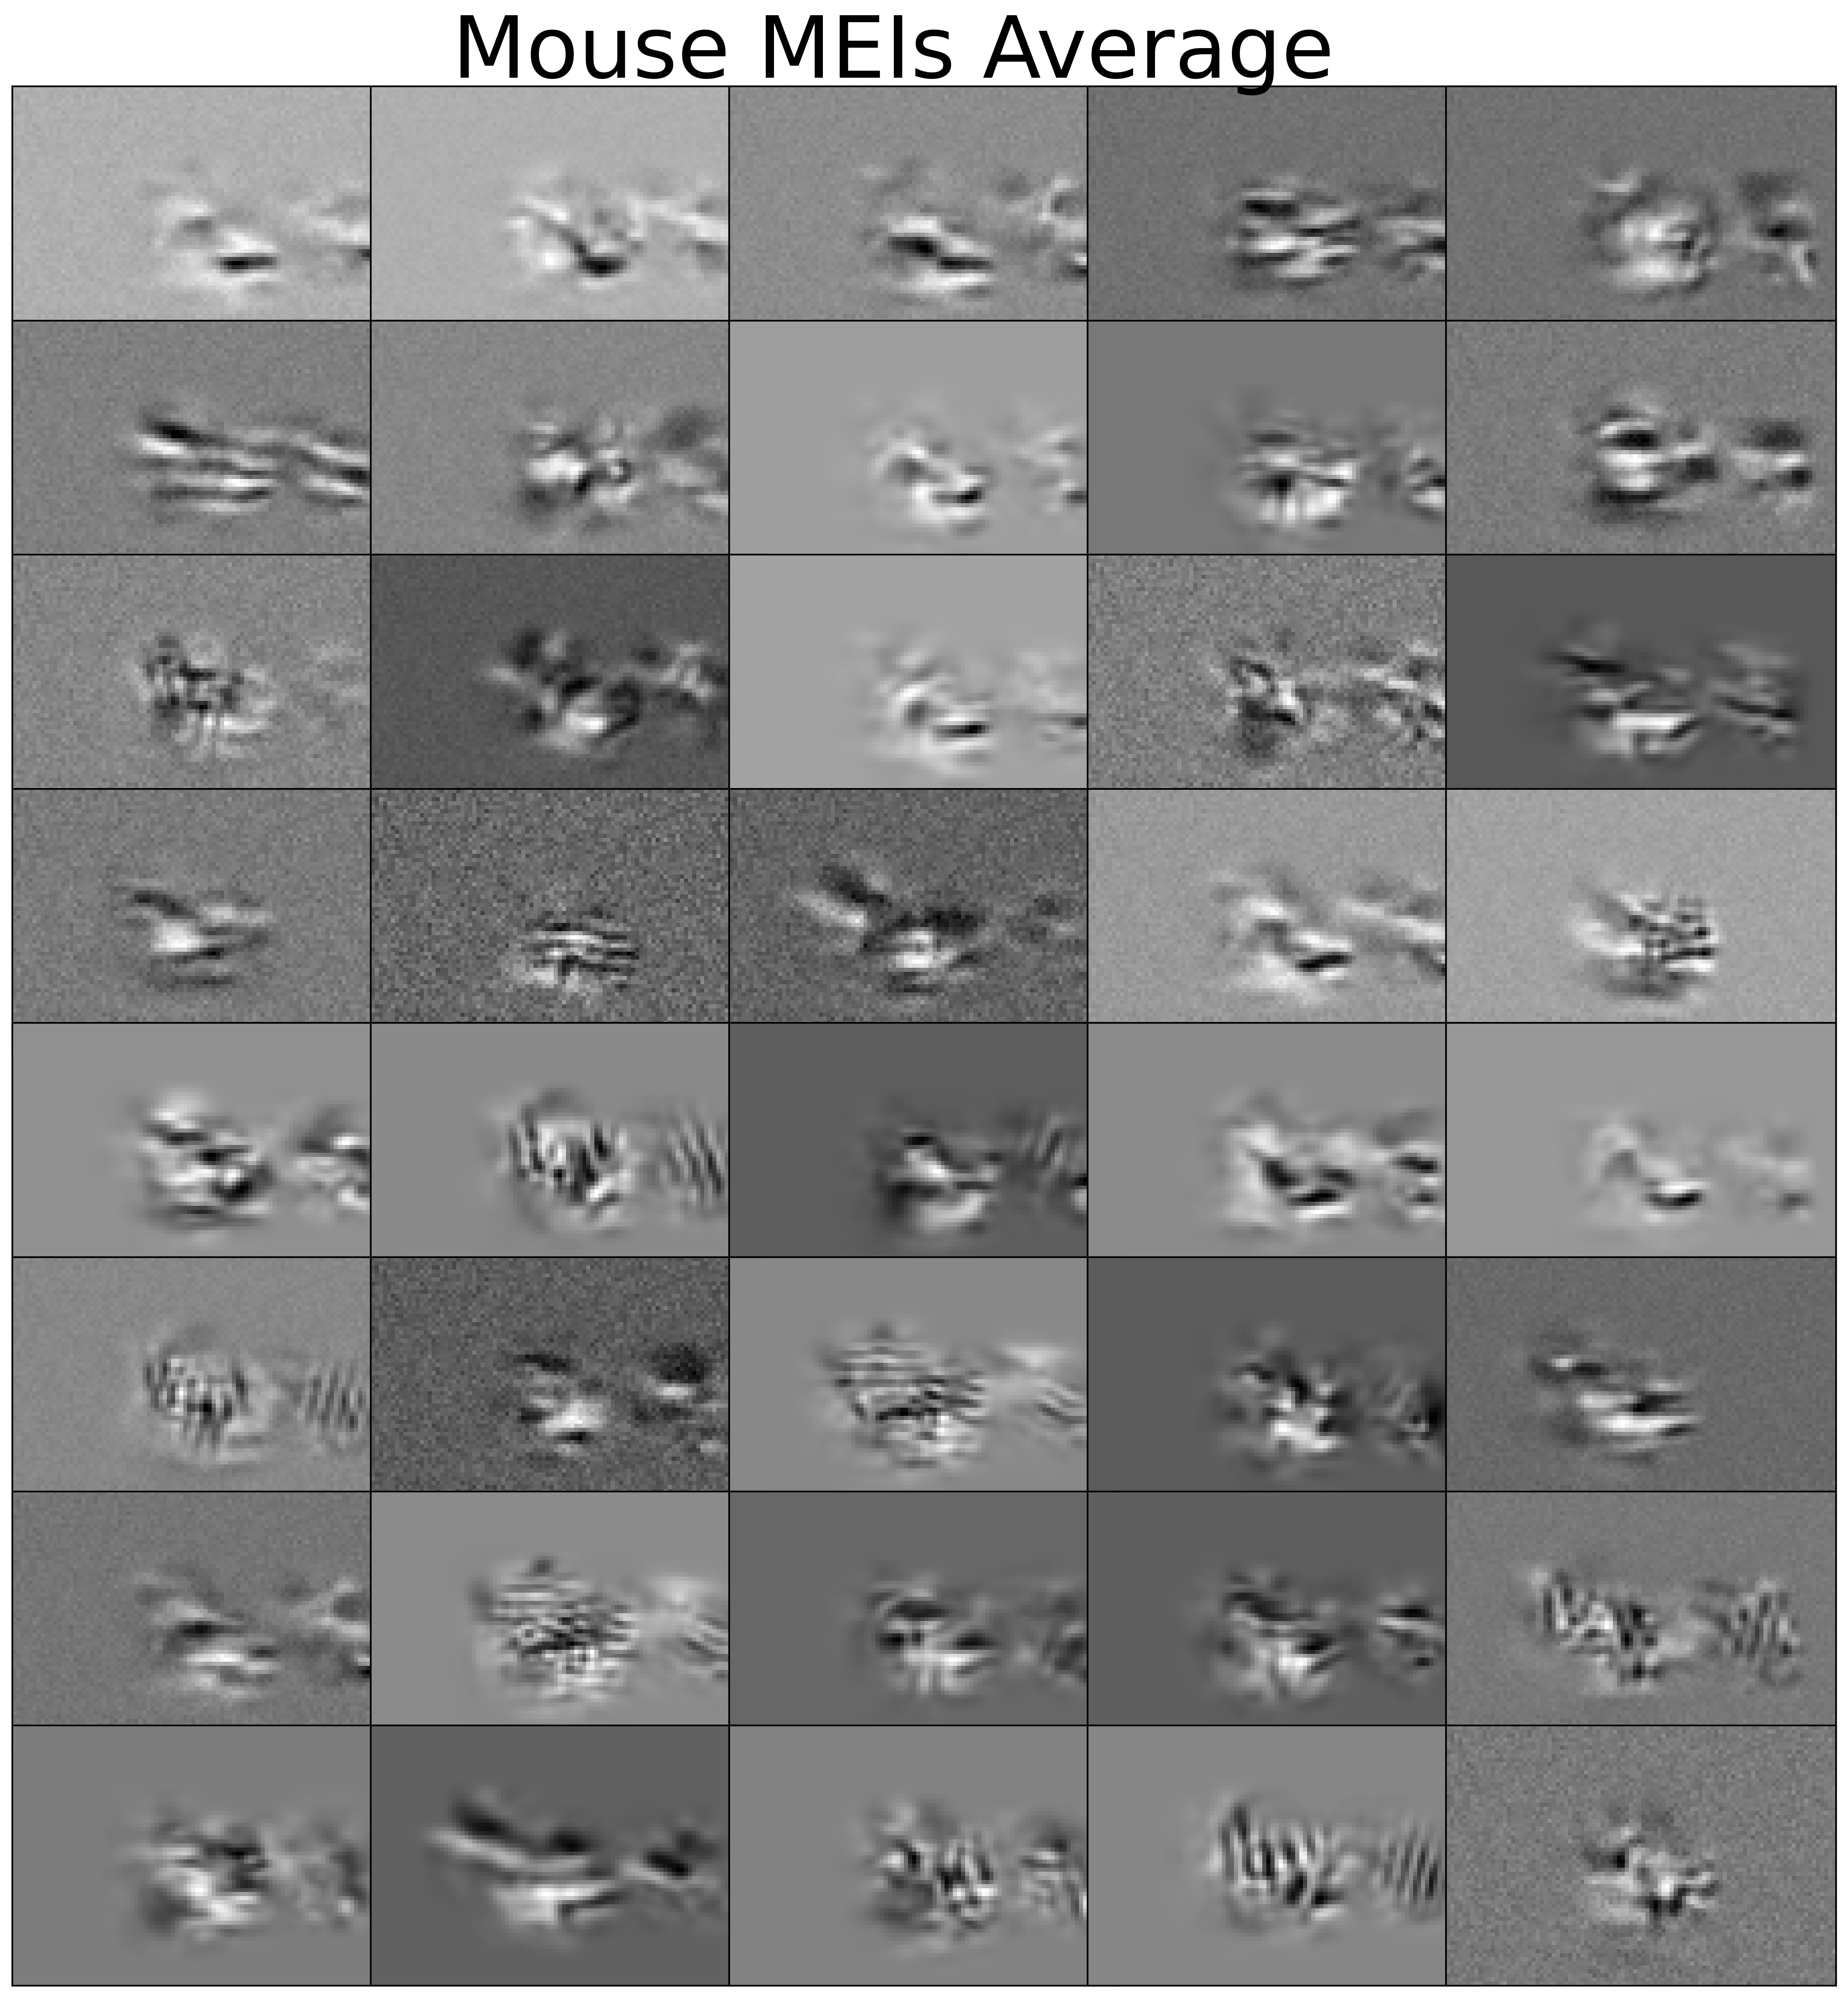

In [104]:
fig, axes = plt.subplots(8,5, figsize=(20,20), dpi=300)
fig.suptitle("Mouse MEIs Average", y=0.91, fontsize=50)
for i in tqdm(range(8)):
    for j in range(5):
        index = i * 5 + j
        axes[i, j].imshow(avg_meis[index][0, 0, :, :], cmap="gray")#, vmin=-1, vmax=1)
        axes[i, j].spines['top'].set_color('black')
        axes[i, j].spines['bottom'].set_color('black')
        axes[i, j].spines['left'].set_color('black')
        axes[i, j].spines['right'].set_color('black')
        axes[i, j].spines['top'].set_linewidth(1)
        axes[i, j].spines['bottom'].set_linewidth(1)
        axes[i, j].spines['left'].set_linewidth(1)
        axes[i, j].spines['right'].set_linewidth(1)
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
plt.subplots_adjust(wspace=-0.25, hspace=-0.1)
os.makedirs("Plots", exist_ok=True)
# plt.savefig("Plots/MouseMEIsTop200Average.png", dpi=300)
plt.show()

In [105]:
# fig, axes = plt.subplots(20,10, figsize=(20,20), dpi=300)
# fig.suptitle("Autistic Mouse", y=0.91, fontsize=50)
# for i in tqdm(range(20)):
#     for j in range(10):
#         index = i * 10 + j
#         axes[i, j].imshow(meis_a[index].reshape(36,64), cmap="gray", vmin=-2, vmax=2)
#         axes[i, j].spines['top'].set_color('black')
#         axes[i, j].spines['bottom'].set_color('black')
#         axes[i, j].spines['left'].set_color('black')
#         axes[i, j].spines['right'].set_color('black')
#         axes[i, j].spines['top'].set_linewidth(1)
#         axes[i, j].spines['bottom'].set_linewidth(1)
#         axes[i, j].spines['left'].set_linewidth(1)
#         axes[i, j].spines['right'].set_linewidth(1)
#         axes[i, j].set_xticks([])
#         axes[i, j].set_yticks([])
# plt.subplots_adjust(wspace=-0.25, hspace=-0.1)
# plt.savefig("Plots/AutisticMouseMEIsTop200.png", dpi=300)

In [106]:
# fig, axes = plt.subplots(20,10, figsize=(20,20), dpi=300)
# plt.suptitle("Wild-type Mouse", y=0.91, fontsize=50)
# for i in range(20):
#     for j in range(10):
#         index = i * 10 + j
#         axes[i, j].imshow(meis_wt[index].reshape(36,64), cmap="gray", vmin=-2, vmax=2)
#         axes[i, j].spines['top'].set_color('black')
#         axes[i, j].spines['bottom'].set_color('black')
#         axes[i, j].spines['left'].set_color('black')
#         axes[i, j].spines['right'].set_color('black')
#         axes[i, j].spines['top'].set_linewidth(1)
#         axes[i, j].spines['bottom'].set_linewidth(1)
#         axes[i, j].spines['left'].set_linewidth(1)
#         axes[i, j].spines['right'].set_linewidth(1)
#         axes[i, j].set_xticks([])
#         axes[i, j].set_yticks([])
# plt.subplots_adjust(wspace=-0.25, hspace=-0.1)
# plt.savefig("Plots/WildtypeMouseMEIsTop200.png", dpi=300)